In [1]:
import os
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy.ndimage import zoom
from scipy.spatial.distance import dice
from tqdm import tqdm
import numba

In [2]:
import plotly.io as pio
pio.renderers.default = "browser"  # or "png", "svg", "json"

## Visualize

In [3]:
def plot_3d_downsampled(data, target_size=100, surface_count=12, color_scale=None):
    """
    Plot a 3D volume with automatic downsampling for performance.
    """
    # Calculate downsampling factor
    current_size = max(data.shape)
    if current_size > target_size:
        factor = target_size / current_size
        # Downsample the data
        data_small = zoom(data, factor, order=1)
        print(f"Downsampled from {data.shape} to {data_small.shape}")
    else:
        data_small = data

    if color_scale is None:
        color_scale = 'agsunset'
    
    # Create coordinate grids
    x, y, z = np.mgrid[0:data_small.shape[0], 0:data_small.shape[1], 0:data_small.shape[2]]

    fig = go.Figure(data=go.Volume(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=data_small.flatten(),
        isomin=data_small.min(),
        isomax=data_small.max(),
        opacity=0.05,
        surface_count=surface_count,
        colorscale=color_scale
    ))
    
    fig.show()

def plot_2d(data):
    """
    Plot a 2D slice of the data.
    """
    plt.imshow(data, cmap='gray')
    plt.axis('off')
    plt.show()

In [17]:
os.environ["nnUNet_raw"] = "/acfs-home/ash4001/ash4001/image-segment/data/cellmap-segmentation-challenge/data/nnUNet_data5/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/acfs-home/ash4001/ash4001/image-segment/data/cellmap-segmentation-challenge/data/nnUNet_data5/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/acfs-home/ash4001/ash4001/image-segment/data/cellmap-segmentation-challenge/data/nnUNet_data5/nnUNet_results"

In [18]:
img_path = os.path.join(os.environ.get("nnUNet_raw"), "Dataset111_CellMapER/imagesTr")
ground_path = os.path.join(os.environ.get("nnUNet_raw"), "Dataset111_CellMapER/labelsTr")
pred_path = os.path.join(os.environ.get("nnUNet_results"), "Dataset111_CellMapER/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_0/pred")
os.path.exists(img_path), os.path.exists(ground_path), os.path.exists(pred_path)

(True, True, True)

In [19]:
print(ground_path)

/acfs-home/ash4001/ash4001/image-segment/data/cellmap-segmentation-challenge/data/nnUNet_data5/nnUNet_raw/Dataset111_CellMapER/labelsTr


In [20]:
i = 2
data = f"em_{i:03d}.tif"
img = tifffile.imread(os.path.join(img_path, data.replace(".tif", "_0000.tif")))
ground = tifffile.imread(os.path.join(ground_path, data))
pred = tifffile.imread(os.path.join(pred_path, data))
print(img.shape, ground.shape)#, pred.shape, type(pred)
print(np.unique(ground, return_counts=True))

(400, 400, 400) (400, 400, 400)
(array([0, 1], dtype=uint8), array([56772423,  7227577]))


In [8]:
plot_3d_downsampled(ground, target_size=32, surface_count=6)#, color_scale='Greys')

Downsampled from (400, 400, 400) to (32, 32, 32)


In [81]:
plot_3d_downsampled(pred, target_size=32, surface_count=6)#, color_scale='Greys')

Downsampled from (400, 400, 400) to (32, 32, 32)


In [21]:
print("image:")
plt.imshow(img[img.shape[0] // 2, :, :], cmap='gray')
plt.show()

print("ground:")
plt.imshow(img[img.shape[0] // 2, :, :], cmap='gray')
plt.imshow(ground[img.shape[0] // 2, :, :], alpha=0.5, cmap='jet')
plt.show()
print("pred:")
plt.imshow(img[img.shape[0] // 2, :, :], cmap='gray')
plt.imshow(pred[img.shape[0] // 2, :, :], alpha=0.5, cmap='jet')
plt.show()

image:
ground:
pred:


# Analyze

In [9]:
data_tag = "nnUNet_data"

raw_path = os.environ.get("nnUNet_raw")
preprocessed_path = os.environ.get("nnUNet_preprocessed")
results_path = os.environ.get("nnUNet_results")
default_tag = raw_path[raw_path.find("nnUNet_data"):raw_path.rfind("/nnUNet_raw")]
raw_path = raw_path.replace(default_tag, data_tag)
preprocessed_path = preprocessed_path.replace(default_tag, data_tag)
results_path = results_path.replace(default_tag, data_tag)

print(raw_path)
print(preprocessed_path)
print(results_path)
print(os.path.exists(raw_path), os.path.exists(preprocessed_path), os.path.exists(results_path))
os.environ["nnUNet_raw"] = raw_path
os.environ["nnUNet_preprocessed"] = preprocessed_path
os.environ["nnUNet_results"] = results_path

/acfs-home/ash4001/ash4001/image-segment/data/cellmap-segmentation-challenge/data/nnUNet_data/nnUNet_raw
/acfs-home/ash4001/ash4001/image-segment/data/cellmap-segmentation-challenge/data/nnUNet_data/nnUNet_preprocessed
/acfs-home/ash4001/ash4001/image-segment/data/cellmap-segmentation-challenge/data/nnUNet_data/nnUNet_results
True True True


### Generate predictions if needed

In [22]:
!pip install batchgenerators acvl_utils nibabel dynamic_network_architectures batchgeneratorsv2

^C
ERROR: Operation cancelled by user


In [23]:
from nnunetv2.paths import nnUNet_results, nnUNet_raw
import torch
from batchgenerators.utilities.file_and_folder_operations import join
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO

# nnUNetv2_predict -d 3 -f 0 -c 3d_lowres -i imagesTs -o imagesTs_predlowres --continue_prediction
fold = 0

# instantiate the nnUNetPredictor
predictor = nnUNetPredictor(
    tile_step_size=0.5,
    use_gaussian=True,
    use_mirroring=True,
    perform_everything_on_device=True,
    device=torch.device('cuda', 0),
    verbose=False,
    verbose_preprocessing=False,
    allow_tqdm=True
)
# initializes the network architecture, loads the checkpoint
predictor.initialize_from_trained_model_folder(
    join(nnUNet_results, 'Dataset111_CellMapER/nnUNetTrainer__nnUNetPlans__3d_fullres'),
    use_folds=(fold,),
    checkpoint_name='checkpoint_best.pth',
)

predictor.predict_from_files(join(nnUNet_raw, 'Dataset111_CellMapER/imagesTr'),
                                join(nnUNet_results, 'Dataset111_CellMapER', 'nnUNetTrainer__nnUNetPlans__3d_fullres', f'fold_{fold}', 'pred'),
                                save_probabilities=False, overwrite=False,
                                num_processes_preprocessing=2, num_processes_segmentation_export=2,
                                folder_with_segs_from_prev_stage=None, num_parts=1, part_id=0)

There are 238 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 238 cases that I would like to predict
overwrite was set to False, so I am only working on cases that haven't been predicted yet. That's 0 cases.


### Visualize Predictions

In [10]:
import json
split_path = "../data/nnUNet_data2/nnUNet_preprocessed/Dataset111_CellMapER/splits_final_verbose.json"
with open(split_path, 'r') as f:
    splits = json.load(f)

fold2val = [s['dataset'] for s in splits]
dataset2files = {s['dataset']:s['val'] for s in splits}
fold2val[0], dataset2files[fold2val[0]][:10]

('jrc_cos7-1a',
 ['em_000',
  'em_001',
  'em_002',
  'em_003',
  'em_004',
  'em_005',
  'em_006',
  'em_007',
  'em_008',
  'em_009'])

In [11]:
#preds_path = "../data/nnUNet_data/nnUNet_results/Dataset111_CellMapER/nnUNetTrainer__nnUNetPlans__3d_fullres/crossval_results_folds_0_1_2_3_4/postprocessed"

dice_scores_folds = []
for fold in range(17):
    preds_path = f"../data/nnUNet_data2/nnUNet_results/Dataset111_CellMapER/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_{fold}/pred"
    ground_path = "../data/nnUNet_data2/nnUNet_raw/Dataset111_CellMapER/labelsTr"

    if os.path.exists(os.path.join(preds_path, "dice_scores.json")):
        with open(os.path.join(preds_path, "dice_scores.json"), 'r') as f:
            dice_scores = json.load(f)
        dice_scores_folds.append(dice_scores)
        print(f"Fold {fold} already has dice scores computed.")
        continue

    pred_files = [f for f in os.listdir(preds_path) if f.endswith(".tif")]
    ground_files = [f for f in os.listdir(ground_path) if f.endswith(".tif")]

    # let's compute the dice score between ground and pred for fold 0
    dice_scores = {}
    for f in tqdm(pred_files, f"files processed (fold {fold})"):
        pred = np.nan_to_num(tifffile.imread(os.path.join(preds_path, f)).flatten(), 0)
        ground = np.nan_to_num(tifffile.imread(os.path.join(ground_path, f)).flatten(), 0)

        # if we want to measure ER only, then also replace all 2s with 0s
        ground[ground == 2] = 0
        pred[pred == 2] = 0

        dice_similarity = 1 - dice(ground, pred) # scipy's dice measures dissimilarity
        dice_scores[f] = dice_similarity
        #print(f, dice_similarity)
    with open(os.path.join(preds_path, "dice_scores.json"), 'w') as f:
        json.dump(dice_scores, f, indent=4)
    dice_scores_folds.append(dice_scores)



Fold 0 already has dice scores computed.
Fold 1 already has dice scores computed.
Fold 2 already has dice scores computed.
Fold 3 already has dice scores computed.
Fold 4 already has dice scores computed.
Fold 5 already has dice scores computed.
Fold 6 already has dice scores computed.
Fold 7 already has dice scores computed.
Fold 8 already has dice scores computed.
Fold 9 already has dice scores computed.
Fold 10 already has dice scores computed.
Fold 11 already has dice scores computed.
Fold 12 already has dice scores computed.
Fold 13 already has dice scores computed.
Fold 14 already has dice scores computed.
Fold 15 already has dice scores computed.
Fold 16 already has dice scores computed.


In [12]:
dataset2dice = {k:[dice_scores_folds[0][f"{f}.tif"] for f in v if not np.isnan(dice_scores[f"{f}.tif"])] for k,v in dataset2files.items()}
print(dataset2dice['jrc_cos7-1a'])

[0.9240441790210377, 0.9453730040149084, 0.764295492032576, 0.8959013387431127, 0.9249814353154673, 0.9180930737103866, 0.9362814637105306, 0.908791803824949, 0.9331174047647512]


### Plotting Function Definitions

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

# Your data preparation
dataset2dice = {k:[dice_scores[f"{f}.tif"] for f in v] for k,v in dataset2files.items()}

def plot_dataset_dice_grid(dataset2dice, grid_cols=3, figsize=(15, 12)):
    """
    Plot dice scores for each dataset in a grid layout
    Each subplot shows the dice scores for all files in that dataset
    """
    datasets = list(dataset2dice.keys())
    n_datasets = len(datasets)
    
    # Calculate grid dimensions
    grid_rows = (n_datasets + grid_cols - 1) // grid_cols
    
    # Create subplots
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=figsize)
    if grid_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_datasets == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Color map for dice scores
    cmap = LinearSegmentedColormap.from_list("dice", ["red", "orange", "yellow", "lightgreen", "green"])
    
    for i, (dataset_name, dice_scores_list) in enumerate(dataset2dice.items()):
        ax = axes[i]
        
        # Create bar plot for this dataset
        x_positions = range(len(dice_scores_list))
        colors = [cmap(score) for score in dice_scores_list]
        
        bars = ax.bar(x_positions, dice_scores_list, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add score labels on bars
        for j, (bar, score) in enumerate(zip(bars, dice_scores_list)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{score:.3f}', ha='center', va='bottom', fontsize=8, rotation=45)
        
        # Customize subplot
        ax.set_ylim(0, 1.1)
        ax.set_xlabel('File Index')
        ax.set_ylabel('Dice Score')
        ax.set_title(f'{dataset_name}\n(n={len(dice_scores_list)}, μ={np.mean(dice_scores_list):.3f})', 
                    fontsize=11, fontweight='bold')
        
        # Add reference lines
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, linewidth=1)
        ax.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, linewidth=1)
        ax.axhline(y=np.mean(dice_scores_list), color='red', linestyle='-', alpha=0.7, linewidth=2)
        
        # Set x-axis ticks
        ax.set_xticks(x_positions[::max(1, len(x_positions)//5)])  # Show every 5th tick if many files
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(n_datasets, len(axes)):
        axes[i].set_visible(False)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes, shrink=0.6, aspect=30)
    cbar.set_label('Dice Score', rotation=270, labelpad=15)
    
    plt.suptitle('Dice Scores by Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_dataset_comparison_heatmap(dataset2dice, figsize=(12, 8)):
    """
    Create a heatmap comparing datasets with summary statistics
    """
    # Calculate summary statistics for each dataset
    dataset_stats = {}
    for dataset, scores in dataset2dice.items():
        dataset_stats[dataset] = {
            'mean': np.mean(scores),
            'median': np.median(scores),
            'std': np.std(scores),
            'min': np.min(scores),
            'max': np.max(scores),
            'count': len(scores)
        }
    
    # Convert to DataFrame
    df_stats = pd.DataFrame(dataset_stats).T
    
    # Create heatmap
    plt.figure(figsize=figsize)
    
    # Create custom annotation
    annot_data = []
    for idx, row in df_stats.iterrows():
        annot_row = []
        for col in df_stats.columns:
            if col == 'count':
                annot_row.append(f'{int(row[col])}')
            else:
                annot_row.append(f'{row[col]:.3f}')
        annot_data.append(annot_row)
    
    sns.heatmap(df_stats, annot=np.array(annot_data), fmt='', cmap='RdYlGn', 
                center=0.5 if 'mean' in df_stats.columns else None, 
                cbar_kws={'label': 'Score Value'})
    
    plt.title('Dataset Comparison - Summary Statistics', fontsize=14, fontweight='bold')
    plt.xlabel('Statistics')
    plt.ylabel('Datasets')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return df_stats

def plot_dataset_boxplots(dataset2dice, figsize=(15, 8)):
    """
    Create box plots comparing dice score distributions across datasets
    """
    # Prepare data for plotting
    datasets = []
    scores = []
    
    for dataset, dice_list in dataset2dice.items():
        datasets.extend([dataset] * len(dice_list))
        scores.extend(dice_list)
    
    # Create DataFrame
    df = pd.DataFrame({'Dataset': datasets, 'Dice_Score': scores})
    
    plt.figure(figsize=figsize)
    
    # Create box plot
    box_plot = plt.boxplot([dataset2dice[dataset] for dataset in dataset2dice.keys()], 
                          labels=list(dataset2dice.keys()), patch_artist=True)
    
    # Color the boxes based on median score
    medians = [np.median(scores) for scores in dataset2dice.values()]
    cmap = plt.cm.RdYlGn
    normalized_medians = [(m - min(medians)) / (max(medians) - min(medians)) if max(medians) != min(medians) else 0.5 
                         for m in medians]
    
    for patch, median_norm in zip(box_plot['boxes'], normalized_medians):
        patch.set_facecolor(cmap(median_norm))
        patch.set_alpha(0.7)
    
    plt.ylabel('Dice Score')
    plt.xlabel('Dataset')
    plt.title('Dice Score Distribution by Dataset', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Add mean markers
    means = [np.mean(scores) for scores in dataset2dice.values()]
    plt.scatter(range(1, len(means) + 1), means, color='red', marker='D', s=50, 
               label='Mean', zorder=5)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_dataset_violin_plots(dataset2dice, figsize=(15, 8)):
    """
    Create violin plots showing score distributions for each dataset
    """
    # Prepare data
    data_for_violin = []
    labels = []
    
    for dataset, scores in dataset2dice.items():
        data_for_violin.append(scores)
        labels.append(f'{dataset}\n(n={len(scores)})')
    
    plt.figure(figsize=figsize)
    
    # Create violin plot
    parts = plt.violinplot(data_for_violin, positions=range(1, len(data_for_violin) + 1),
                          showmeans=True, showmedians=True)
    
    # Color the violins
    colors = plt.cm.Set3(np.linspace(0, 1, len(data_for_violin)))
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha='right')
    plt.ylabel('Dice Score')
    plt.title('Dice Score Distributions by Dataset (Violin Plot)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_dataset_summary_table(dataset2dice):
    """
    Create a summary table of dataset statistics
    """
    summary_data = []
    
    for dataset, scores in dataset2dice.items():
        summary_data.append({
            'Dataset': dataset,
            'Count': len(scores),
            'Mean': f"{np.mean(scores):.3f}",
            'Median': f"{np.median(scores):.3f}",
            'Std': f"{np.std(scores):.3f}",
            'Min': f"{np.min(scores):.3f}",
            'Max': f"{np.max(scores):.3f}",
            'Range': f"{np.max(scores) - np.min(scores):.3f}"
        })
    
    df_summary = pd.DataFrame(summary_data)
    
    # Display as a nice table
    fig, ax = plt.subplots(figsize=(12, len(summary_data) * 0.5 + 2))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=df_summary.values,
                    colLabels=df_summary.columns,
                    cellLoc='center',
                    loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    # Color code the header
    for i in range(len(df_summary.columns)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code mean scores
    mean_col_idx = df_summary.columns.get_loc('Mean')
    for i in range(1, len(summary_data) + 1):
        mean_val = float(df_summary.iloc[i-1]['Mean'])
        if mean_val >= 0.8:
            color = '#90EE90'  # Light green
        elif mean_val >= 0.6:
            color = '#FFE4B5'  # Light yellow
        else:
            color = '#FFB6C1'  # Light red
        table[(i, mean_col_idx)].set_facecolor(color)
    
    plt.title('Dataset Summary Statistics', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    return df_summary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

def plot_all_folds_grid(dice_scores_folds, dataset2files, figsize=(15, 20)):
    """
    Plot dice scores for all folds in a vertical grid layout
    Each row represents a fold, with a line plot showing performance across datasets
    """
    n_folds = len(dice_scores_folds)
    datasets = list(dataset2files.keys())
    n_datasets = len(datasets)
    
    # Create the grid: rows = folds (vertically stacked)
    fig, axes = plt.subplots(n_folds, 1, figsize=figsize, 
                            gridspec_kw={'hspace': 0.4})
    
    # Ensure axes is a list for single fold case
    if n_folds == 1:
        axes = [axes]
    
    # Color map and markers for datasets
    colors = plt.cm.Set1(np.linspace(0, 1, n_datasets))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x']
    
    # Track global min/max for consistent y-axis scaling
    all_scores = []
    for fold in range(n_folds):
        dice_scores = dice_scores_folds[fold]
        for dataset, files in dataset2files.items():
            valid_scores = [dice_scores[f"{f}.tif"] for f in files 
                          if f"{f}.tif" in dice_scores and not np.isnan(dice_scores[f"{f}.tif"])]
            all_scores.extend(valid_scores)
    
    y_min, y_max = min(all_scores) if all_scores else 0, max(all_scores) if all_scores else 1
    y_range = y_max - y_min
    y_lim_min = max(0, y_min - 0.1 * y_range)
    y_lim_max = min(1, y_max + 0.1 * y_range)
    
    # Plot each fold
    for fold_idx in range(n_folds):
        ax = axes[fold_idx]
        dice_scores = dice_scores_folds[fold_idx]
        
        # Collect data for this fold across all datasets
        dataset_means = []
        dataset_stds = []
        dataset_counts = []
        valid_datasets = []
        
        for dataset_idx, (dataset, files) in enumerate(dataset2files.items()):
            valid_scores = [dice_scores[f"{f}.tif"] for f in files 
                          if f"{f}.tif" in dice_scores and not np.isnan(dice_scores[f"{f}.tif"])]
            
            if len(valid_scores) > 0:
                dataset_means.append(np.mean(valid_scores))
                dataset_stds.append(np.std(valid_scores))
                dataset_counts.append(len(valid_scores))
                valid_datasets.append((dataset_idx, dataset))
        
        if valid_datasets:
            # Plot line with error bars and markers
            x_positions = [idx for idx, _ in valid_datasets]
            
            # Main line plot
            line = ax.plot(x_positions, dataset_means, 
                          linewidth=3, marker='o', markersize=8, 
                          color='steelblue', alpha=0.8, label='Mean')[0]
            
            # Error bars
            ax.errorbar(x_positions, dataset_means, yerr=dataset_stds, 
                       fmt='none', ecolor='steelblue', alpha=0.6, 
                       capsize=5, capthick=2)
            
            # Individual dataset markers with different colors
            for i, (pos, mean, count) in enumerate(zip(x_positions, dataset_means, dataset_counts)):
                marker_idx = i % len(markers)
                color_idx = i % len(colors)
                
                # Main marker
                ax.scatter([pos], [mean], color=colors[color_idx], 
                          marker=markers[marker_idx], s=100, 
                          edgecolors='black', linewidths=1, zorder=5)
                
                # Add count annotation
                ax.annotate(f'n={count}', (pos, mean), 
                           textcoords="offset points", xytext=(0, 15), 
                           ha='center', fontsize=8, 
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
        # Customize subplot
        ax.set_ylim(y_lim_min, y_lim_max)
        ax.set_xlim(-0.5, n_datasets - 0.5)
        
        # Set x-axis
        ax.set_xticks(range(n_datasets))
        if fold_idx == n_folds - 1:  # Only on bottom plot
            ax.set_xticklabels([dataset for dataset in datasets], 
                              rotation=45, ha='right')
        else:
            ax.set_xticklabels([])
        
        # Labels and title
        ax.set_ylabel('Dice Score', fontsize=12)
        ax.set_title(f'Fold {fold_idx} - Performance Across Datasets', 
                    fontsize=14, fontweight='bold', pad=10)
        
        # Add reference lines
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, linewidth=1, label='Threshold 0.5')
        ax.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, linewidth=1, label='Threshold 0.8')
        
        # Add overall fold statistics
        if valid_datasets:
            overall_mean = np.mean(dataset_means)
            overall_std = np.std(dataset_means)
            stats_text = f'Fold Mean: {overall_mean:.3f} ± {overall_std:.3f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
        
        # Grid
        ax.grid(True, alpha=0.3)
        
        # Legend only on first plot
        if fold_idx == 0:
            ax.legend(loc='upper right', fontsize=10)
    
    # Add overall title
    plt.suptitle('Dice Scores Across All Folds and Datasets', fontsize=18, fontweight='bold', y=0.98)
    
    # Add bottom label
    axes[-1].set_xlabel('Datasets', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_folds_summary_heatmap(dice_scores_folds, dataset2files, figsize=(12, 8)):
    """
    Create a heatmap showing mean dice scores for each fold-dataset combination
    """
    n_folds = len(dice_scores_folds)
    datasets = list(dataset2files.keys())
    
    # Create summary matrix
    summary_matrix = np.full((n_folds, len(datasets)), np.nan)
    count_matrix = np.zeros((n_folds, len(datasets)))
    
    for fold_idx in range(n_folds):
        dice_scores = dice_scores_folds[fold_idx]
        
        for dataset_idx, (dataset, files) in enumerate(dataset2files.items()):
            valid_scores = [dice_scores[f"{f}.tif"] for f in files 
                          if f"{f}.tif" in dice_scores and not np.isnan(dice_scores[f"{f}.tif"])]
            
            if len(valid_scores) > 0:
                summary_matrix[fold_idx, dataset_idx] = np.mean(valid_scores)
                count_matrix[fold_idx, dataset_idx] = len(valid_scores)
    
    # Create annotations with mean and count
    annotations = np.empty((n_folds, len(datasets)), dtype=object)
    for i in range(n_folds):
        for j in range(len(datasets)):
            if not np.isnan(summary_matrix[i, j]):
                annotations[i, j] = f'{summary_matrix[i, j]:.3f}\n(n={int(count_matrix[i, j])})'
            else:
                annotations[i, j] = 'N/A'
    
    plt.figure(figsize=figsize)
    
    # Create heatmap
    mask = np.isnan(summary_matrix)
    sns.heatmap(summary_matrix, 
                annot=annotations, 
                fmt='', 
                cmap='RdYlGn', 
                mask=mask,
                xticklabels=datasets,
                yticklabels=[f'Fold {i}' for i in range(n_folds)],
                cbar_kws={'label': 'Mean Dice Score'},
                vmin=0, vmax=1)
    
    plt.title('Mean Dice Scores: Folds vs Datasets', fontsize=14, fontweight='bold')
    plt.xlabel('Datasets')
    plt.ylabel('Folds')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_folds_comparison_lines(dice_scores_folds, dataset2files, figsize=(15, 10)):
    """
    Create line plots showing how each dataset performs across folds
    """
    datasets = list(dataset2files.keys())
    n_datasets = len(datasets)
    n_folds = len(dice_scores_folds)
    
    # Calculate grid dimensions for subplots
    cols = min(3, n_datasets)
    rows = (n_datasets + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    colors = plt.cm.Set1(np.linspace(0, 1, n_datasets))
    
    for dataset_idx, dataset in enumerate(datasets):
        ax = axes[dataset_idx] if dataset_idx < len(axes) else None
        if ax is None:
            continue
            
        # Collect data for this dataset across all folds
        fold_means = []
        fold_stds = []
        fold_counts = []
        
        for fold_idx in range(n_folds):
            dice_scores = dice_scores_folds[fold_idx]
            files = dataset2files[dataset]
            
            valid_scores = [dice_scores[f"{f}.tif"] for f in files 
                          if f"{f}.tif" in dice_scores and not np.isnan(dice_scores[f"{f}.tif"])]
            
            if len(valid_scores) > 0:
                fold_means.append(np.mean(valid_scores))
                fold_stds.append(np.std(valid_scores))
                fold_counts.append(len(valid_scores))
            else:
                fold_means.append(np.nan)
                fold_stds.append(np.nan)
                fold_counts.append(0)
        
        # Plot line with error bars
        folds = list(range(n_folds))
        valid_indices = [i for i, mean in enumerate(fold_means) if not np.isnan(mean)]
        
        if valid_indices:
            valid_folds = [folds[i] for i in valid_indices]
            valid_means = [fold_means[i] for i in valid_indices]
            valid_stds = [fold_stds[i] for i in valid_indices]
            
            ax.errorbar(valid_folds, valid_means, yerr=valid_stds, 
                       marker='o', linewidth=2, markersize=8, 
                       color=colors[dataset_idx], capsize=5, capthick=2)
            
            # Add count annotations
            for fold, mean, count in zip(valid_folds, valid_means, [fold_counts[i] for i in valid_indices]):
                ax.annotate(f'n={count}', (fold, mean), textcoords="offset points", 
                           xytext=(0,10), ha='center', fontsize=8)
        
        # Customize subplot
        ax.set_title(f'{dataset}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Fold')
        ax.set_ylabel('Dice Score')
        ax.set_xticks(range(n_folds))
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        
        # Add reference lines
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5)
        ax.axhline(y=0.8, color='green', linestyle='--', alpha=0.5)
    
    # Hide unused subplots
    for i in range(n_datasets, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Dataset Performance Across Folds', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Usage example:
print("Background Classification, by fold:")
print("Generating combined visualization for all folds...")

Background Classification, by fold:
Generating combined visualization for all folds...


## Background Classification, 5-folds crossval models

/tmp/ipykernel_1924882/2694912757.py:340: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter([pos], [mean], color=colors[color_idx],
/tmp/ipykernel_1924882/2694912757.py:340: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter([pos], [mean], color=colors[color_idx],
/tmp/ipykernel_1924882/2694912757.py:340: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter([pos], [mean], color=colors[color_idx],
/tmp/ipykernel_1924882/2694912757.py:340: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplo

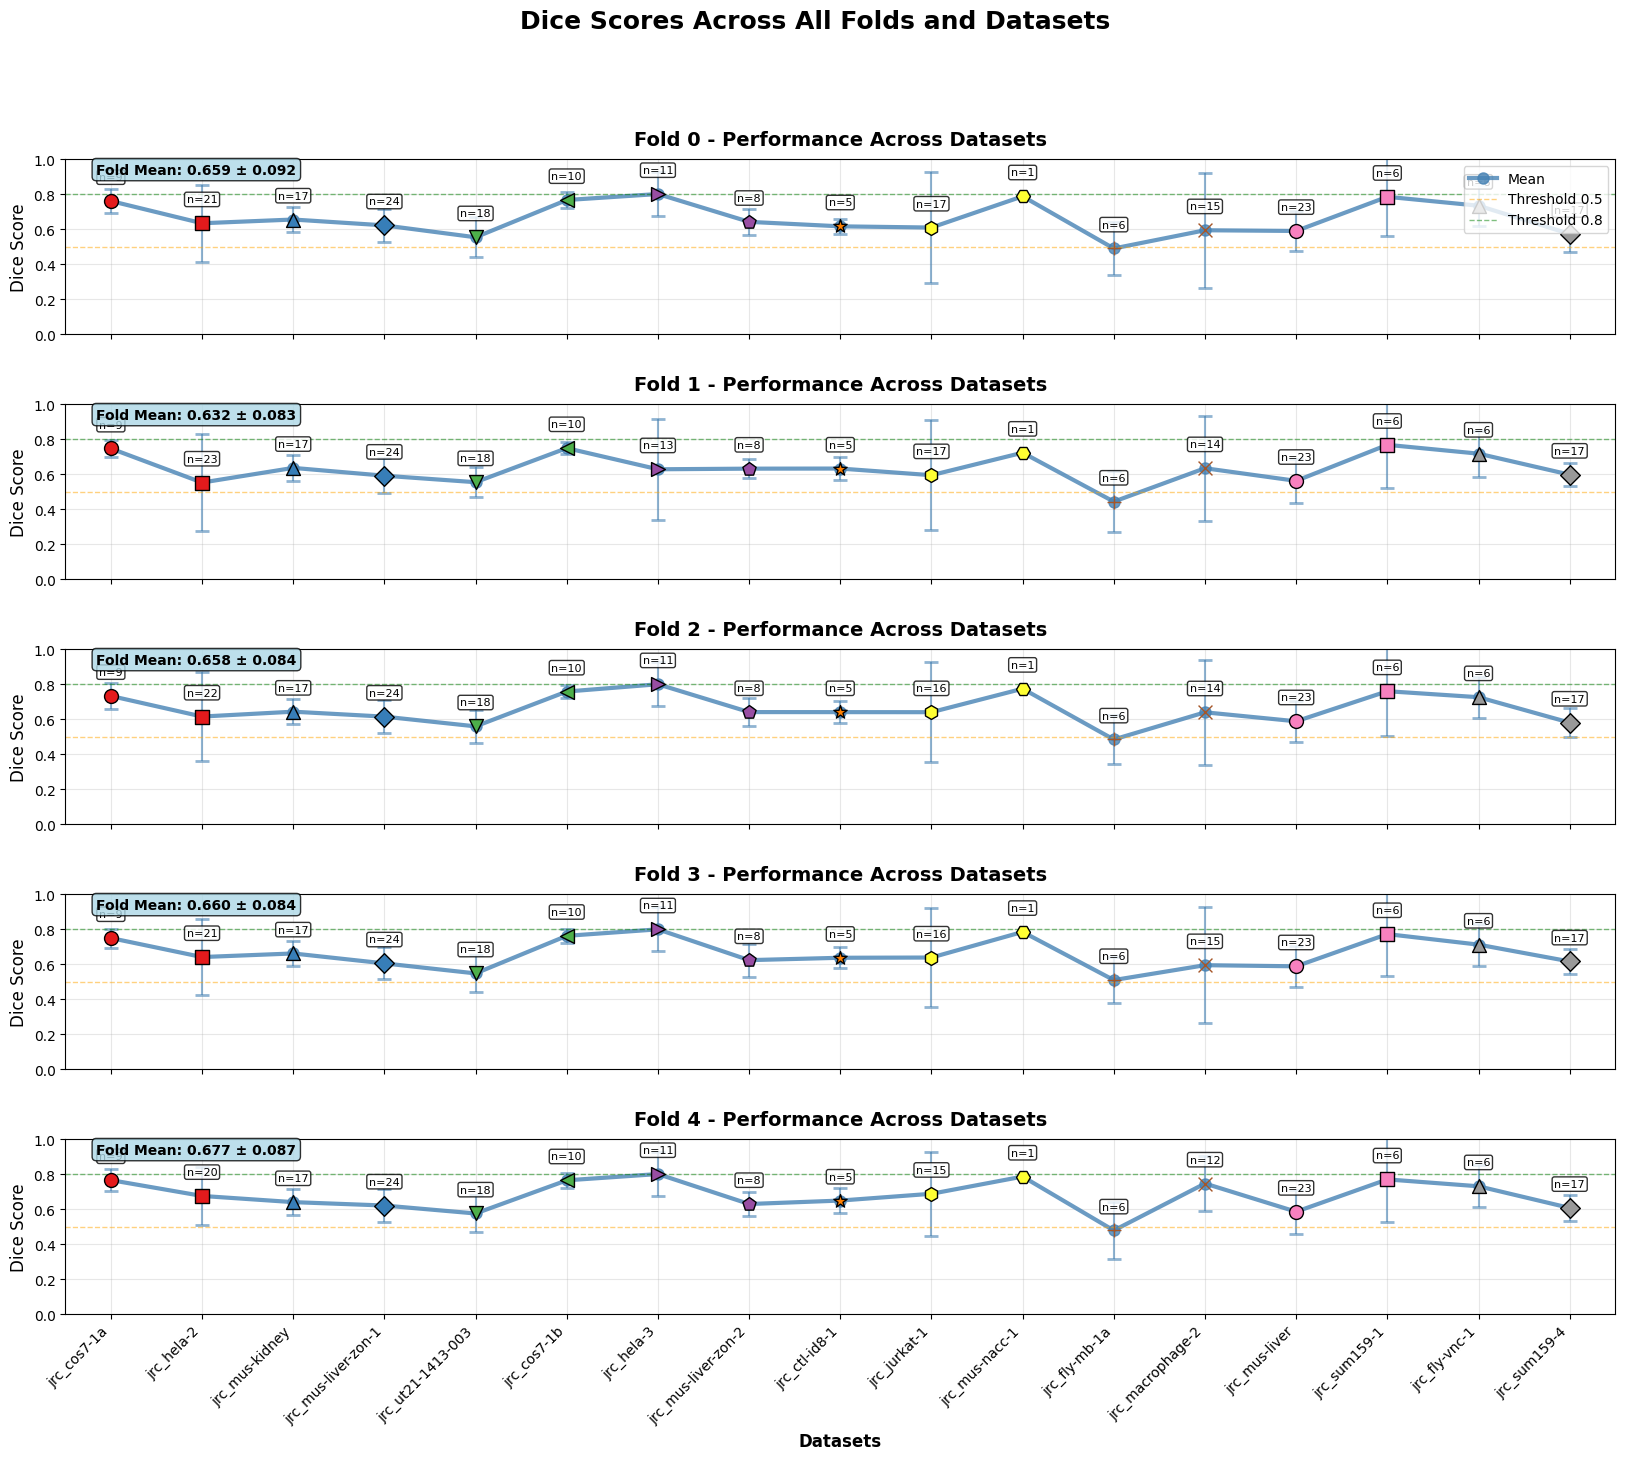

In [17]:
plot_all_folds_grid(dice_scores_folds, dataset2files, figsize=(20, 15))

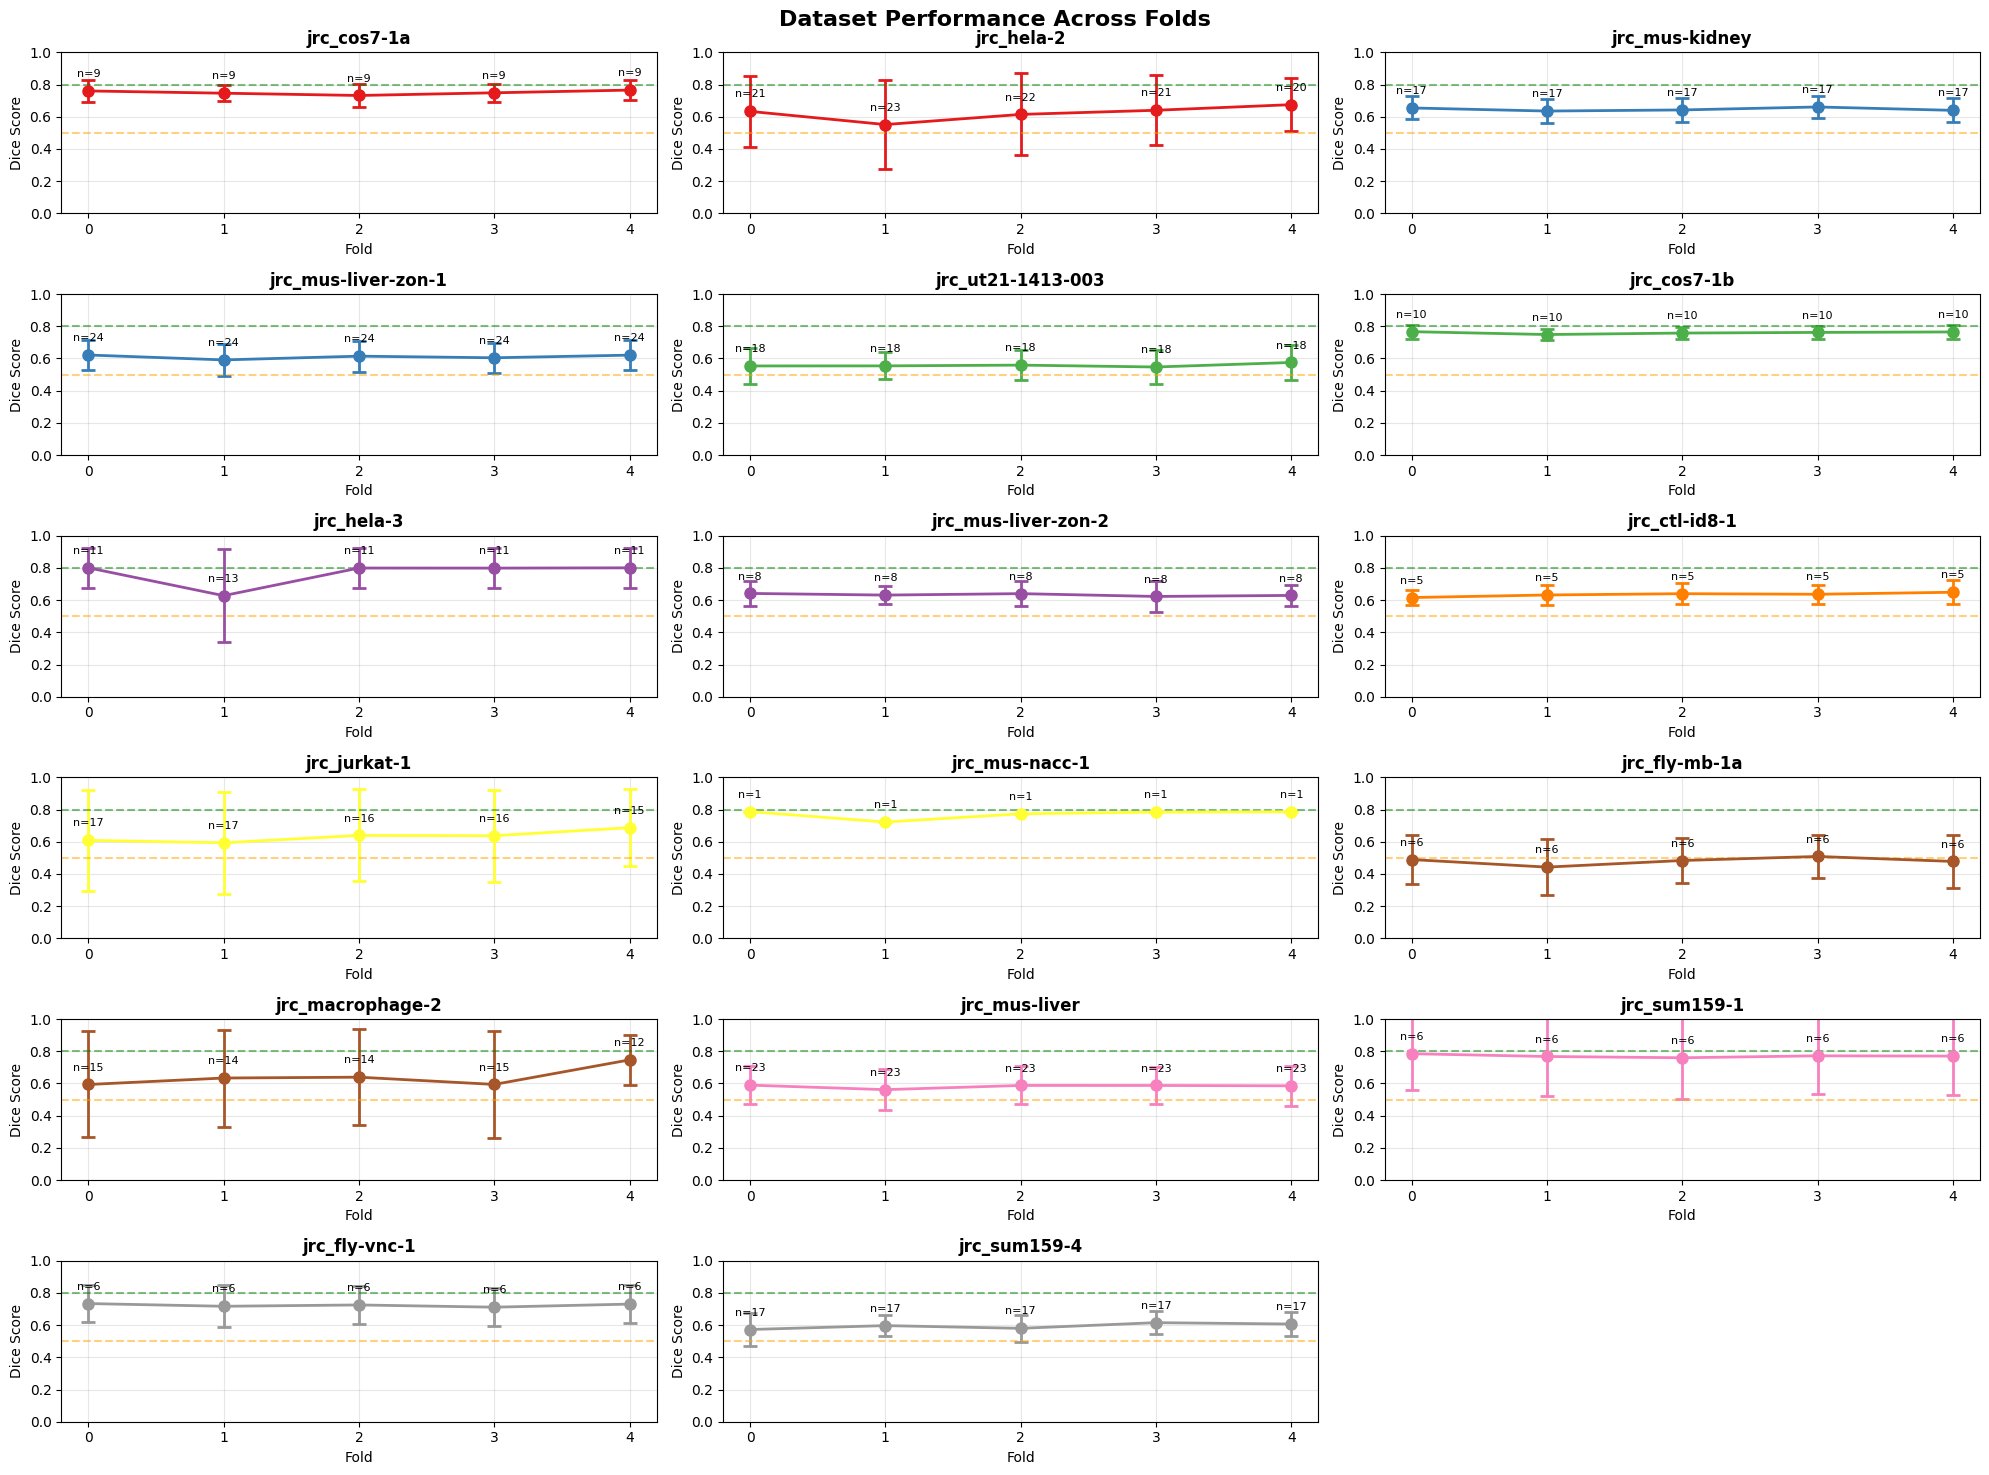

In [18]:
plot_folds_comparison_lines(dice_scores_folds, dataset2files, figsize=(20, 15))

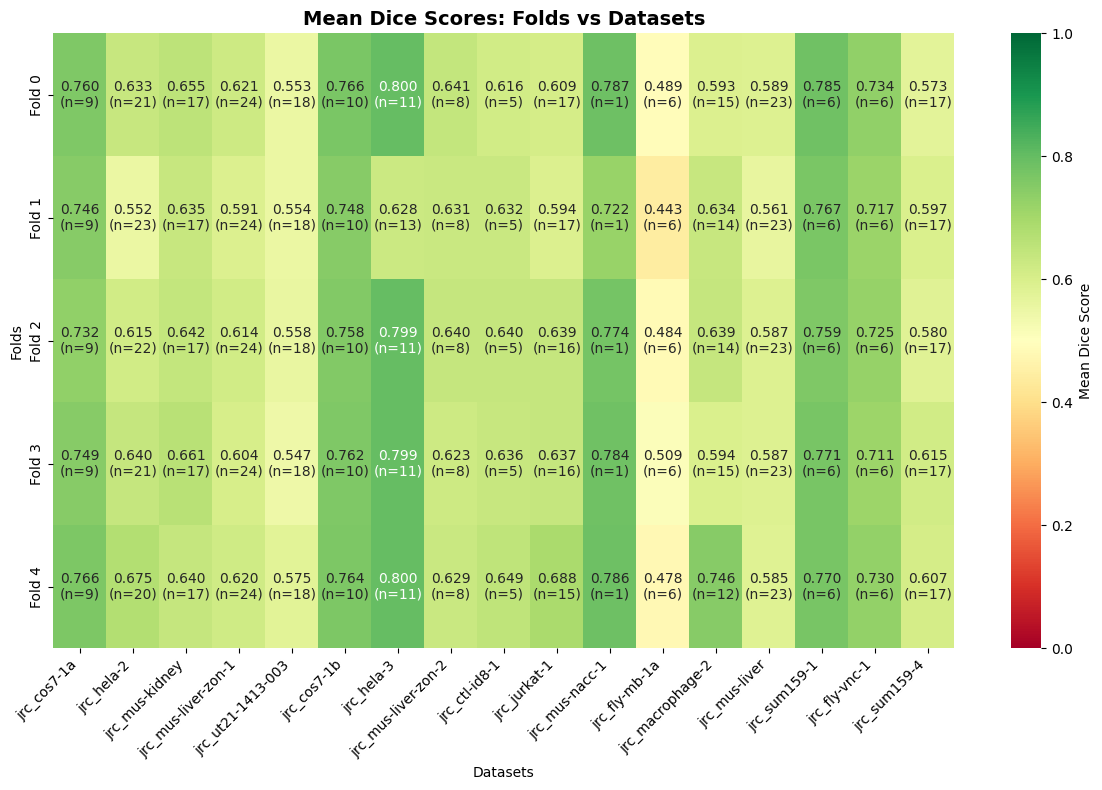

In [14]:
plot_folds_summary_heatmap(dice_scores_folds, dataset2files, figsize=(12, 8))

Results for fold 0


/tmp/ipykernel_1924882/2694912757.py:143: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot([dataset2dice[dataset] for dataset in dataset2dice.keys()],


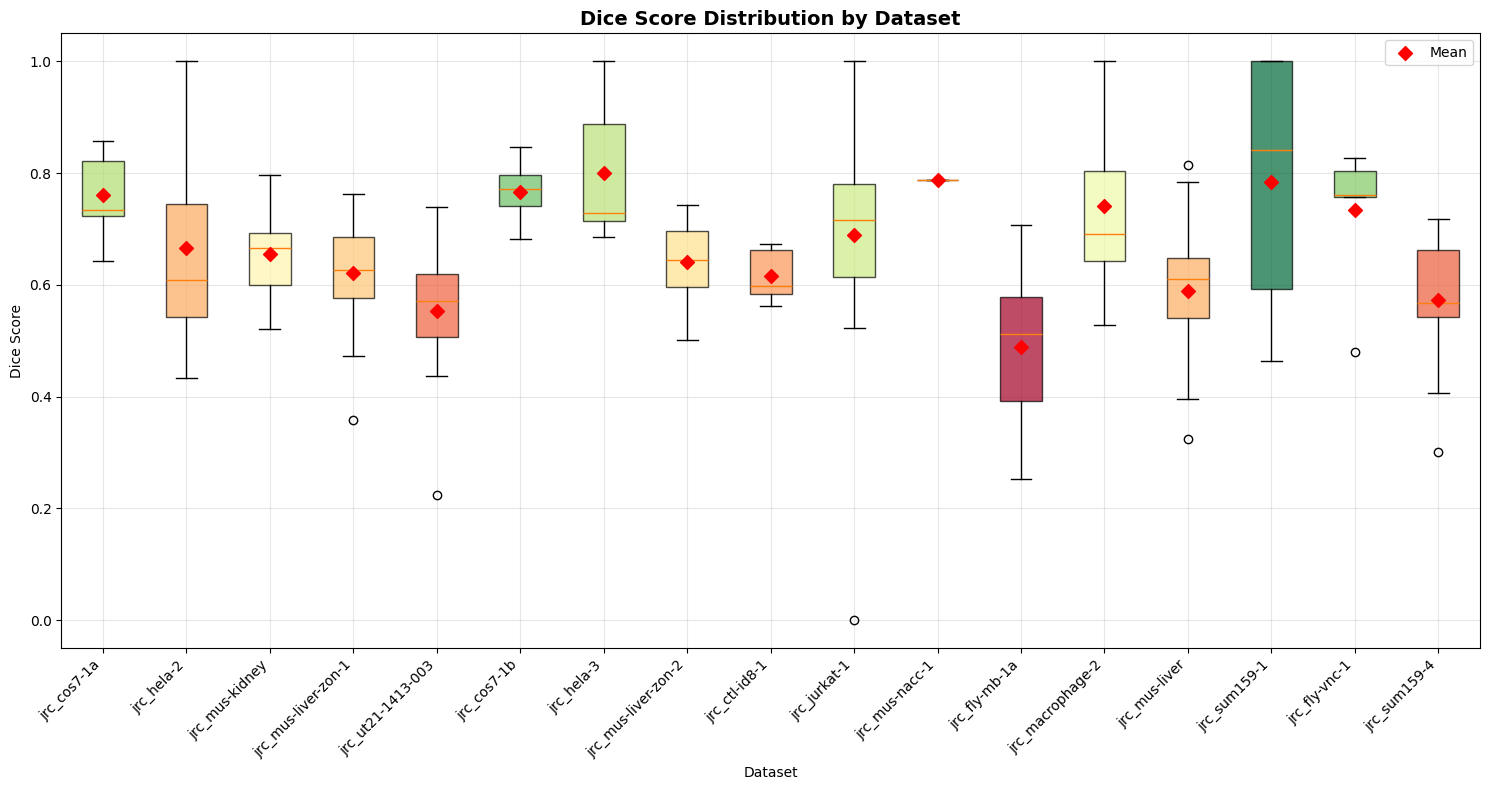

In [19]:
# Background Classification, by fold
fold = 0
print("Results for fold", fold)
dataset2dice = {k:[dice_scores_folds[fold][f"{f}.tif"] for f in v if not np.isnan(dice_scores[f"{f}.tif"])] for k,v in dataset2files.items()}
plot_dataset_boxplots(dataset2dice)

## ER Classification, 5-fold crossval model ensemble

Results for Ensemble Mmodel 0


/tmp/ipykernel_1924882/2694912757.py:143: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot([dataset2dice[dataset] for dataset in dataset2dice.keys()],


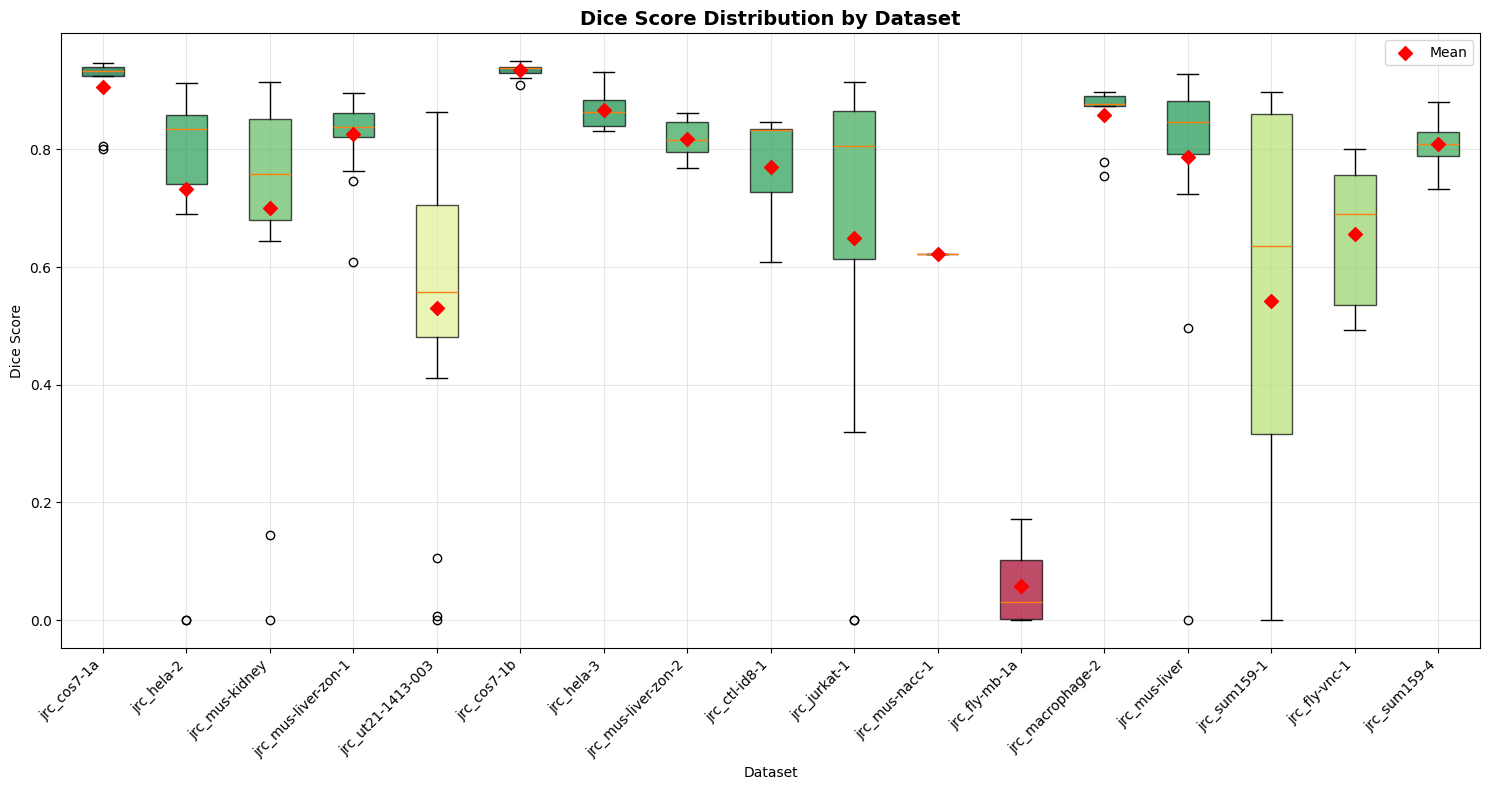

In [32]:
# ER Classification, by fold
fold = 0
print("Results for Ensemble Mmodel", fold)
dataset2dice = {k:[dice_scores_folds[fold][f"{f}.tif"] for f in v if not np.isnan(dice_scores[f"{f}.tif"])] for k,v in dataset2files.items()}
plot_dataset_boxplots(dataset2dice)

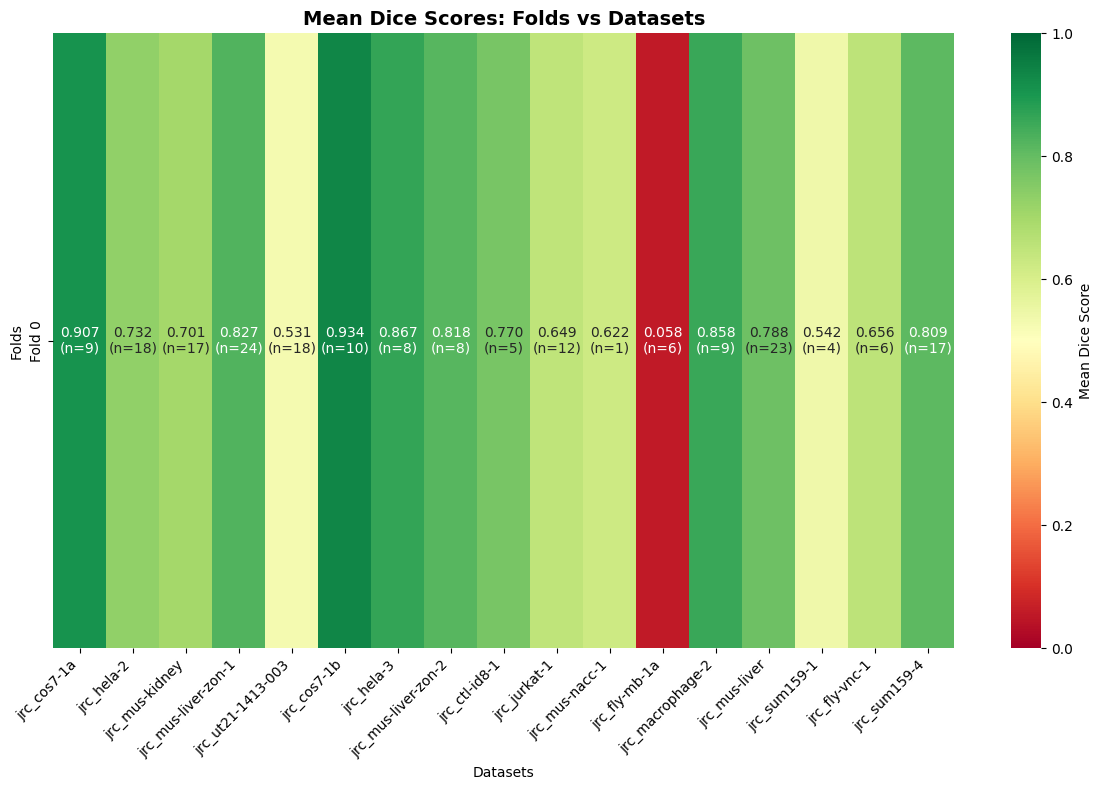

In [42]:
plot_folds_summary_heatmap(dice_scores_folds, dataset2files, figsize=(12, 8))

## ER Classification, 17 dataset folds models

/tmp/ipykernel_3333585/2694912757.py:340: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter([pos], [mean], color=colors[color_idx],
/tmp/ipykernel_3333585/2694912757.py:340: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter([pos], [mean], color=colors[color_idx],
/tmp/ipykernel_3333585/2694912757.py:340: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter([pos], [mean], color=colors[color_idx],
/tmp/ipykernel_3333585/2694912757.py:340: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplo

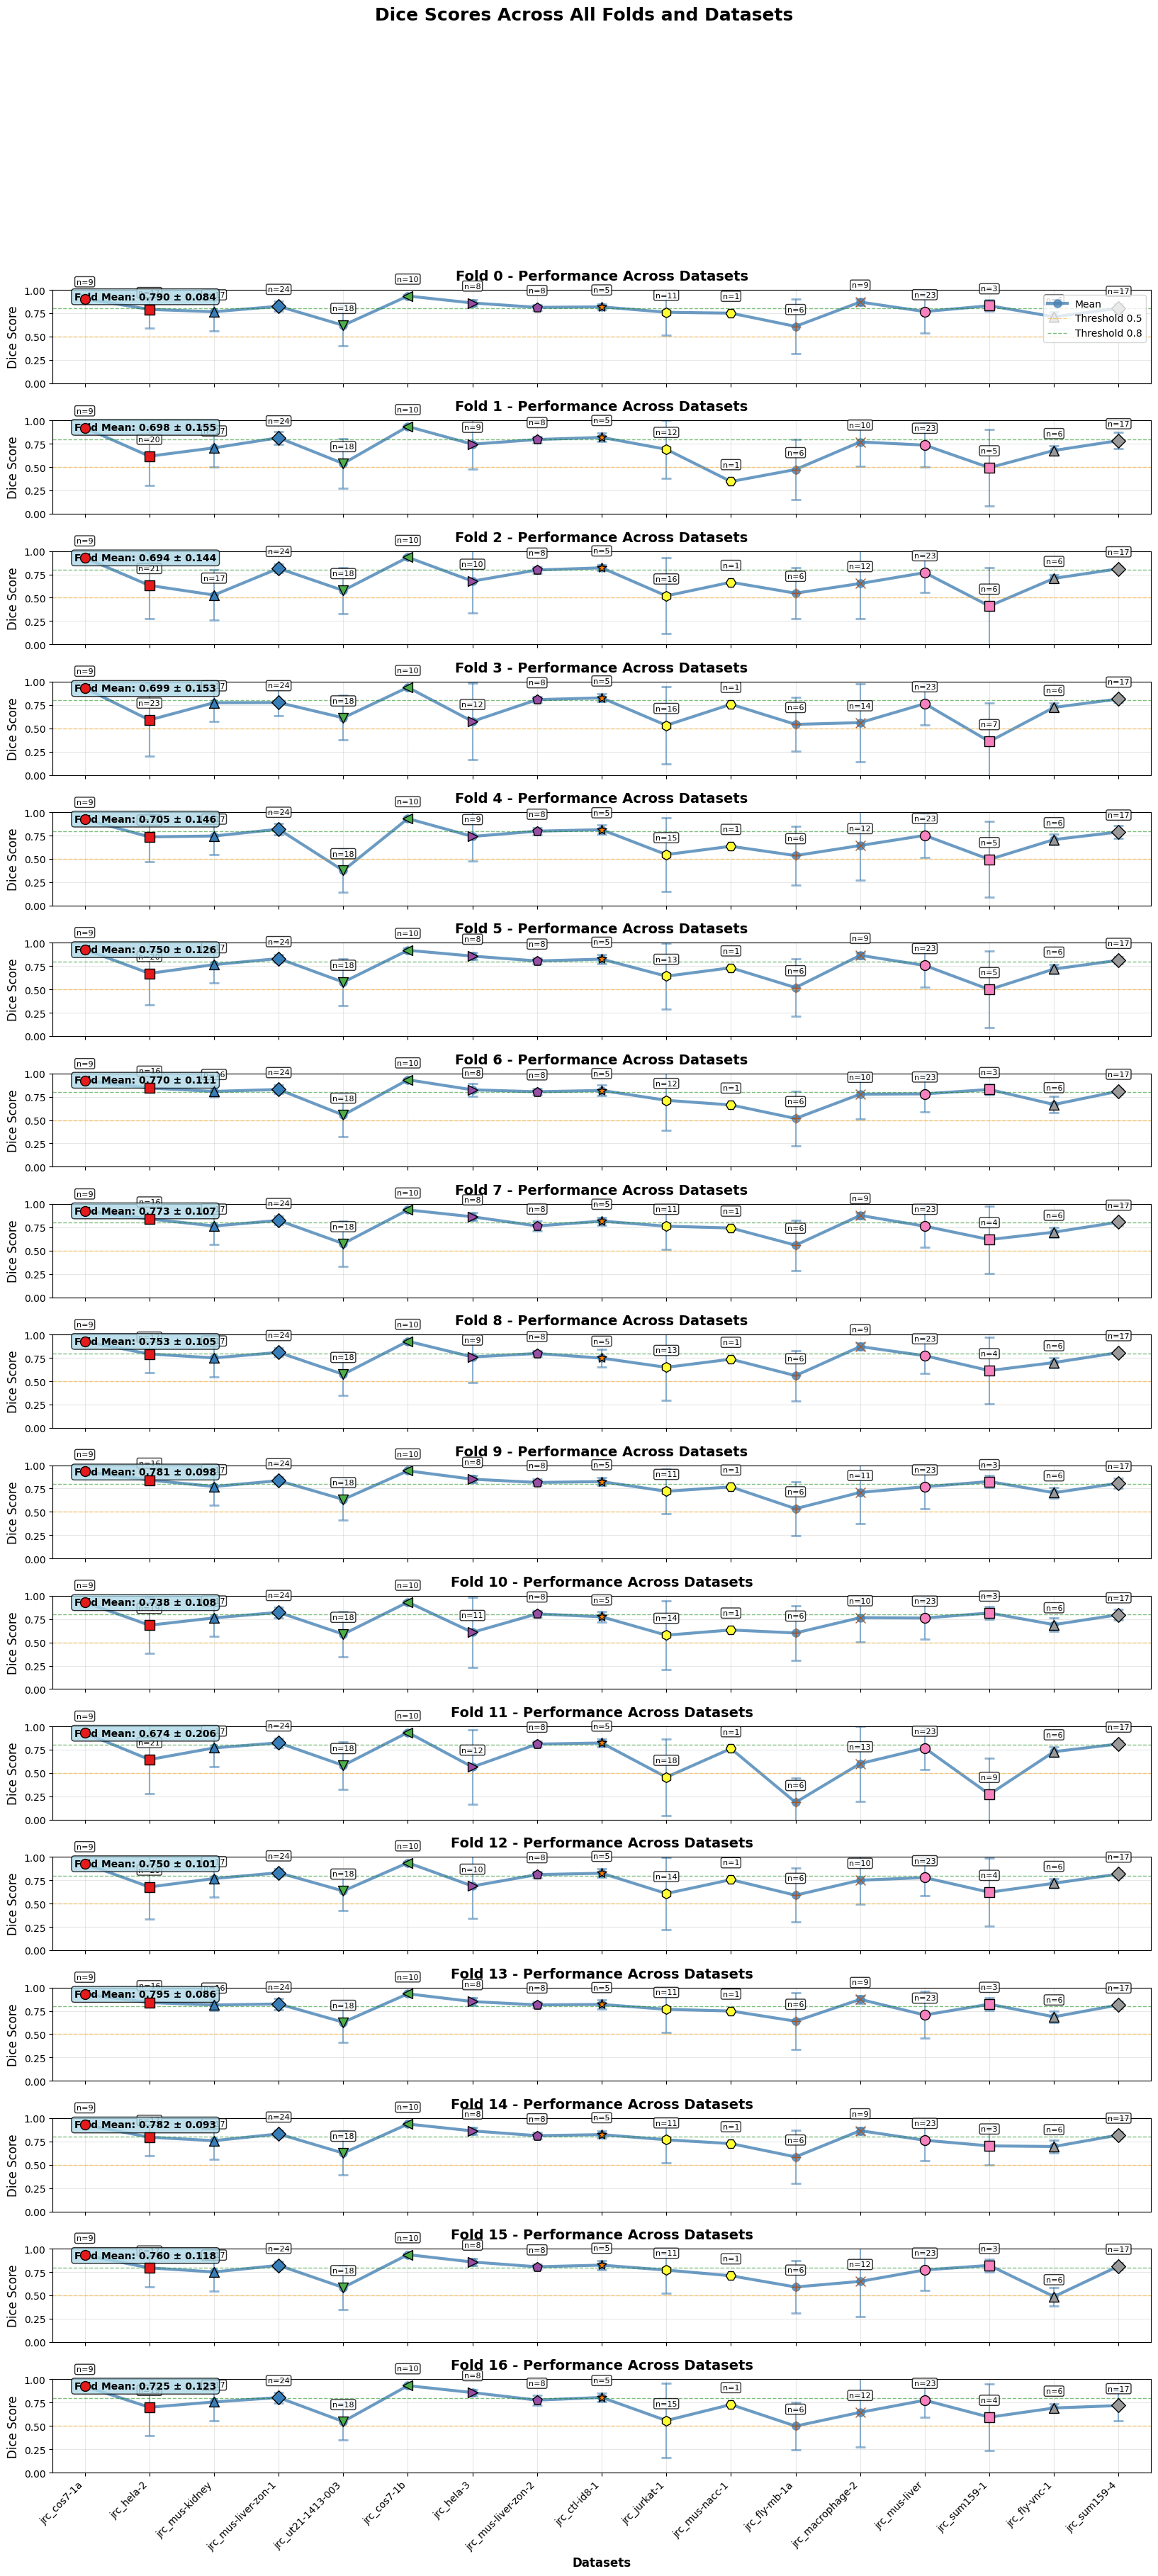

In [34]:
plot_all_folds_grid(dice_scores_folds, dataset2files, figsize=(20, 40))

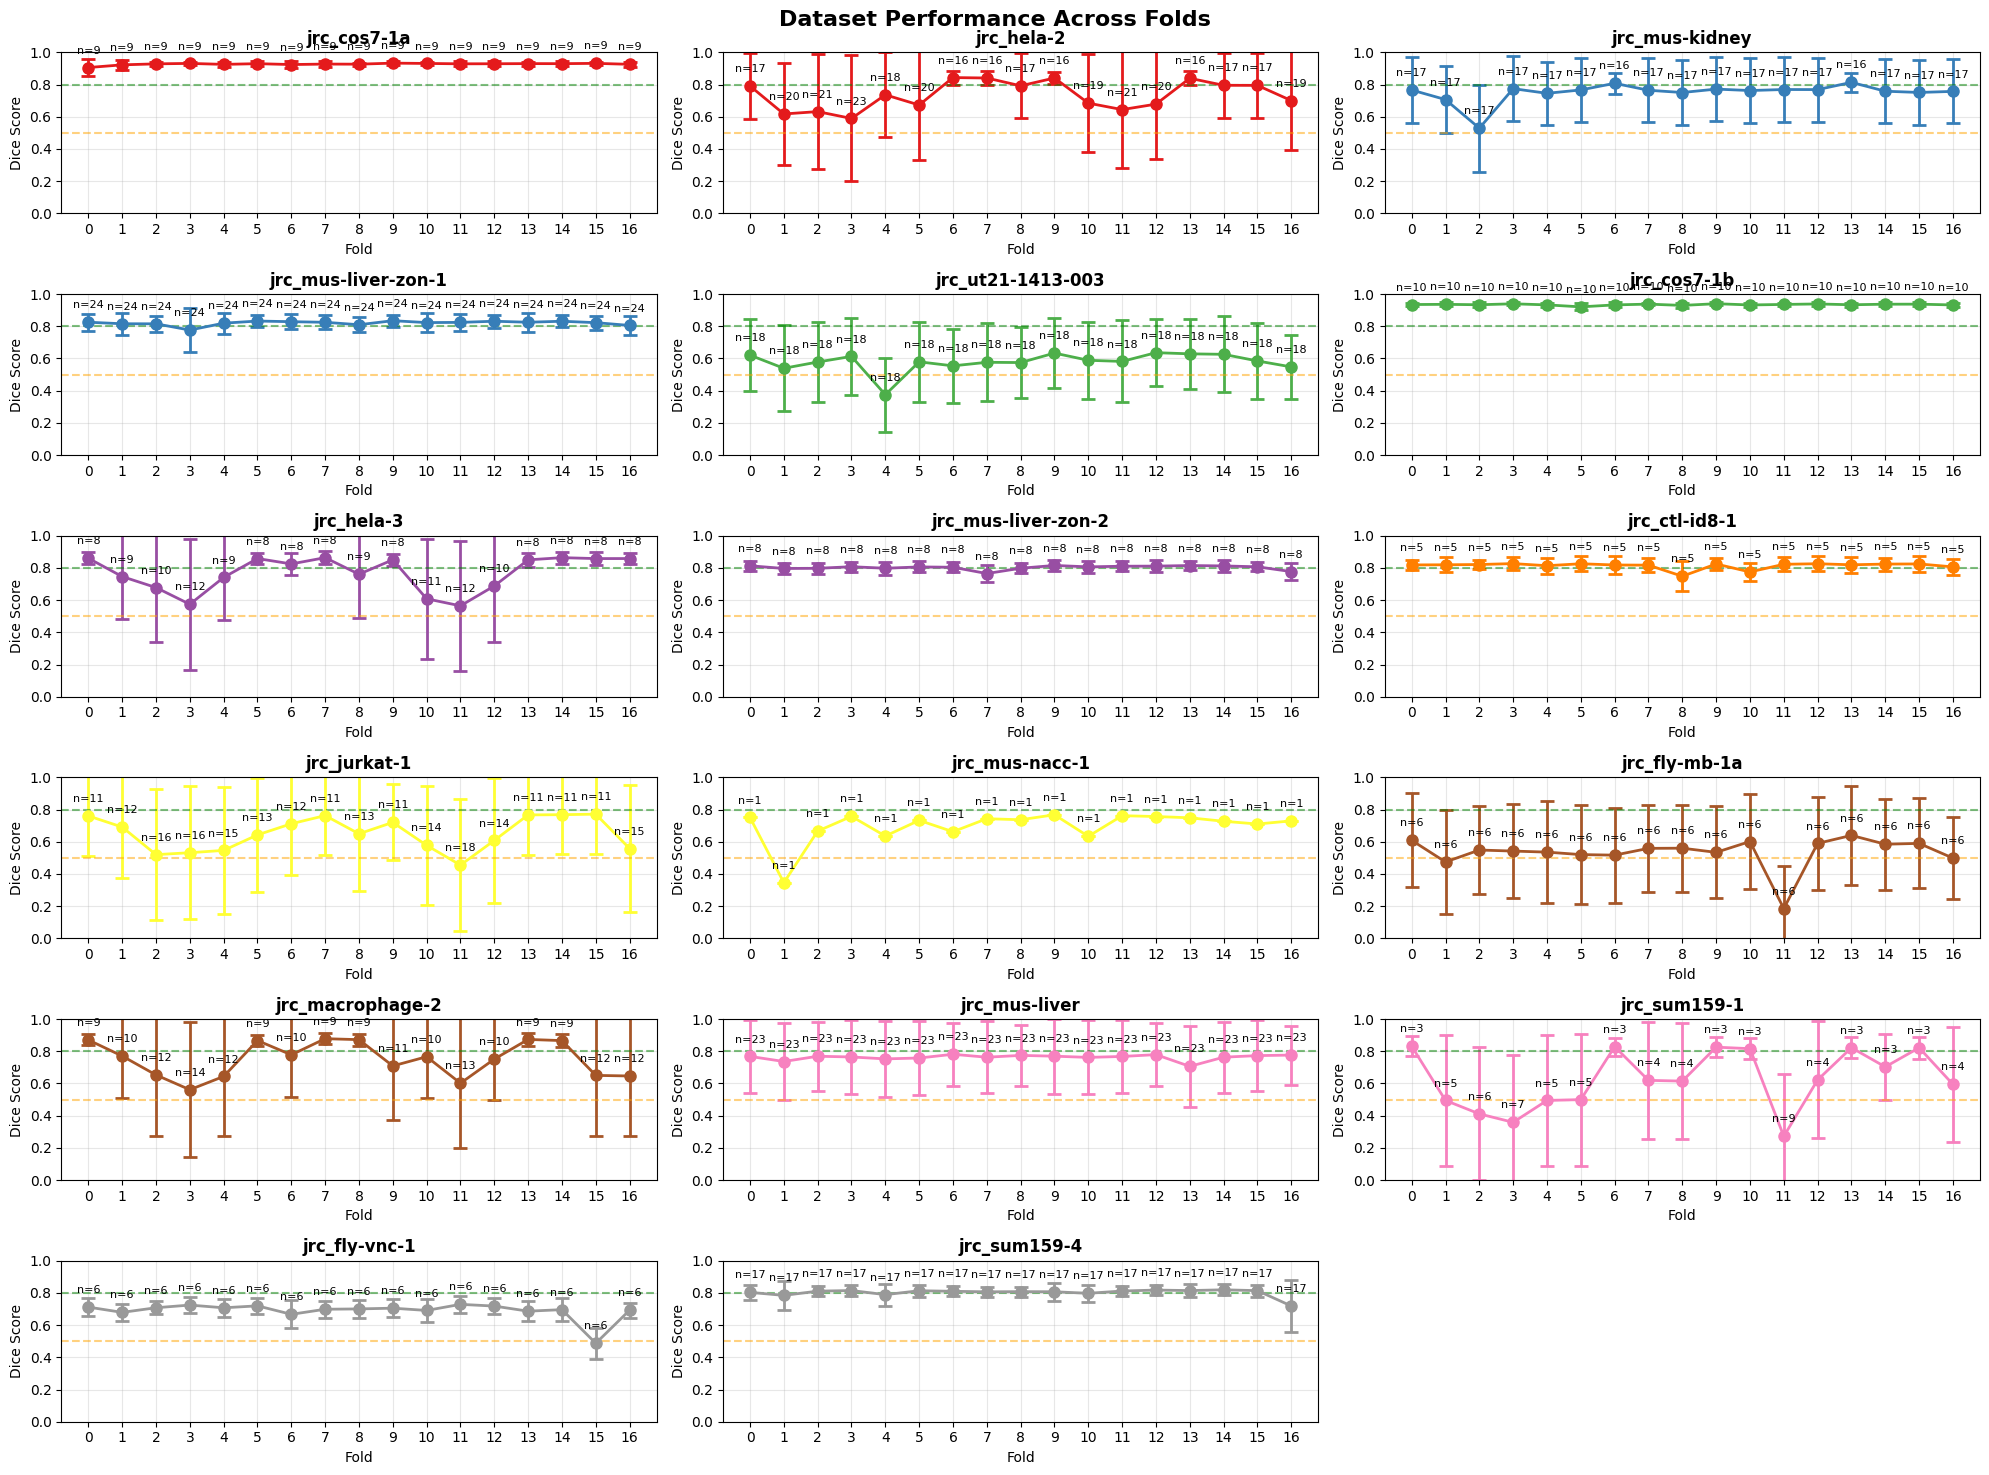

In [31]:
plot_folds_comparison_lines(dice_scores_folds, dataset2files, figsize=(20, 15))

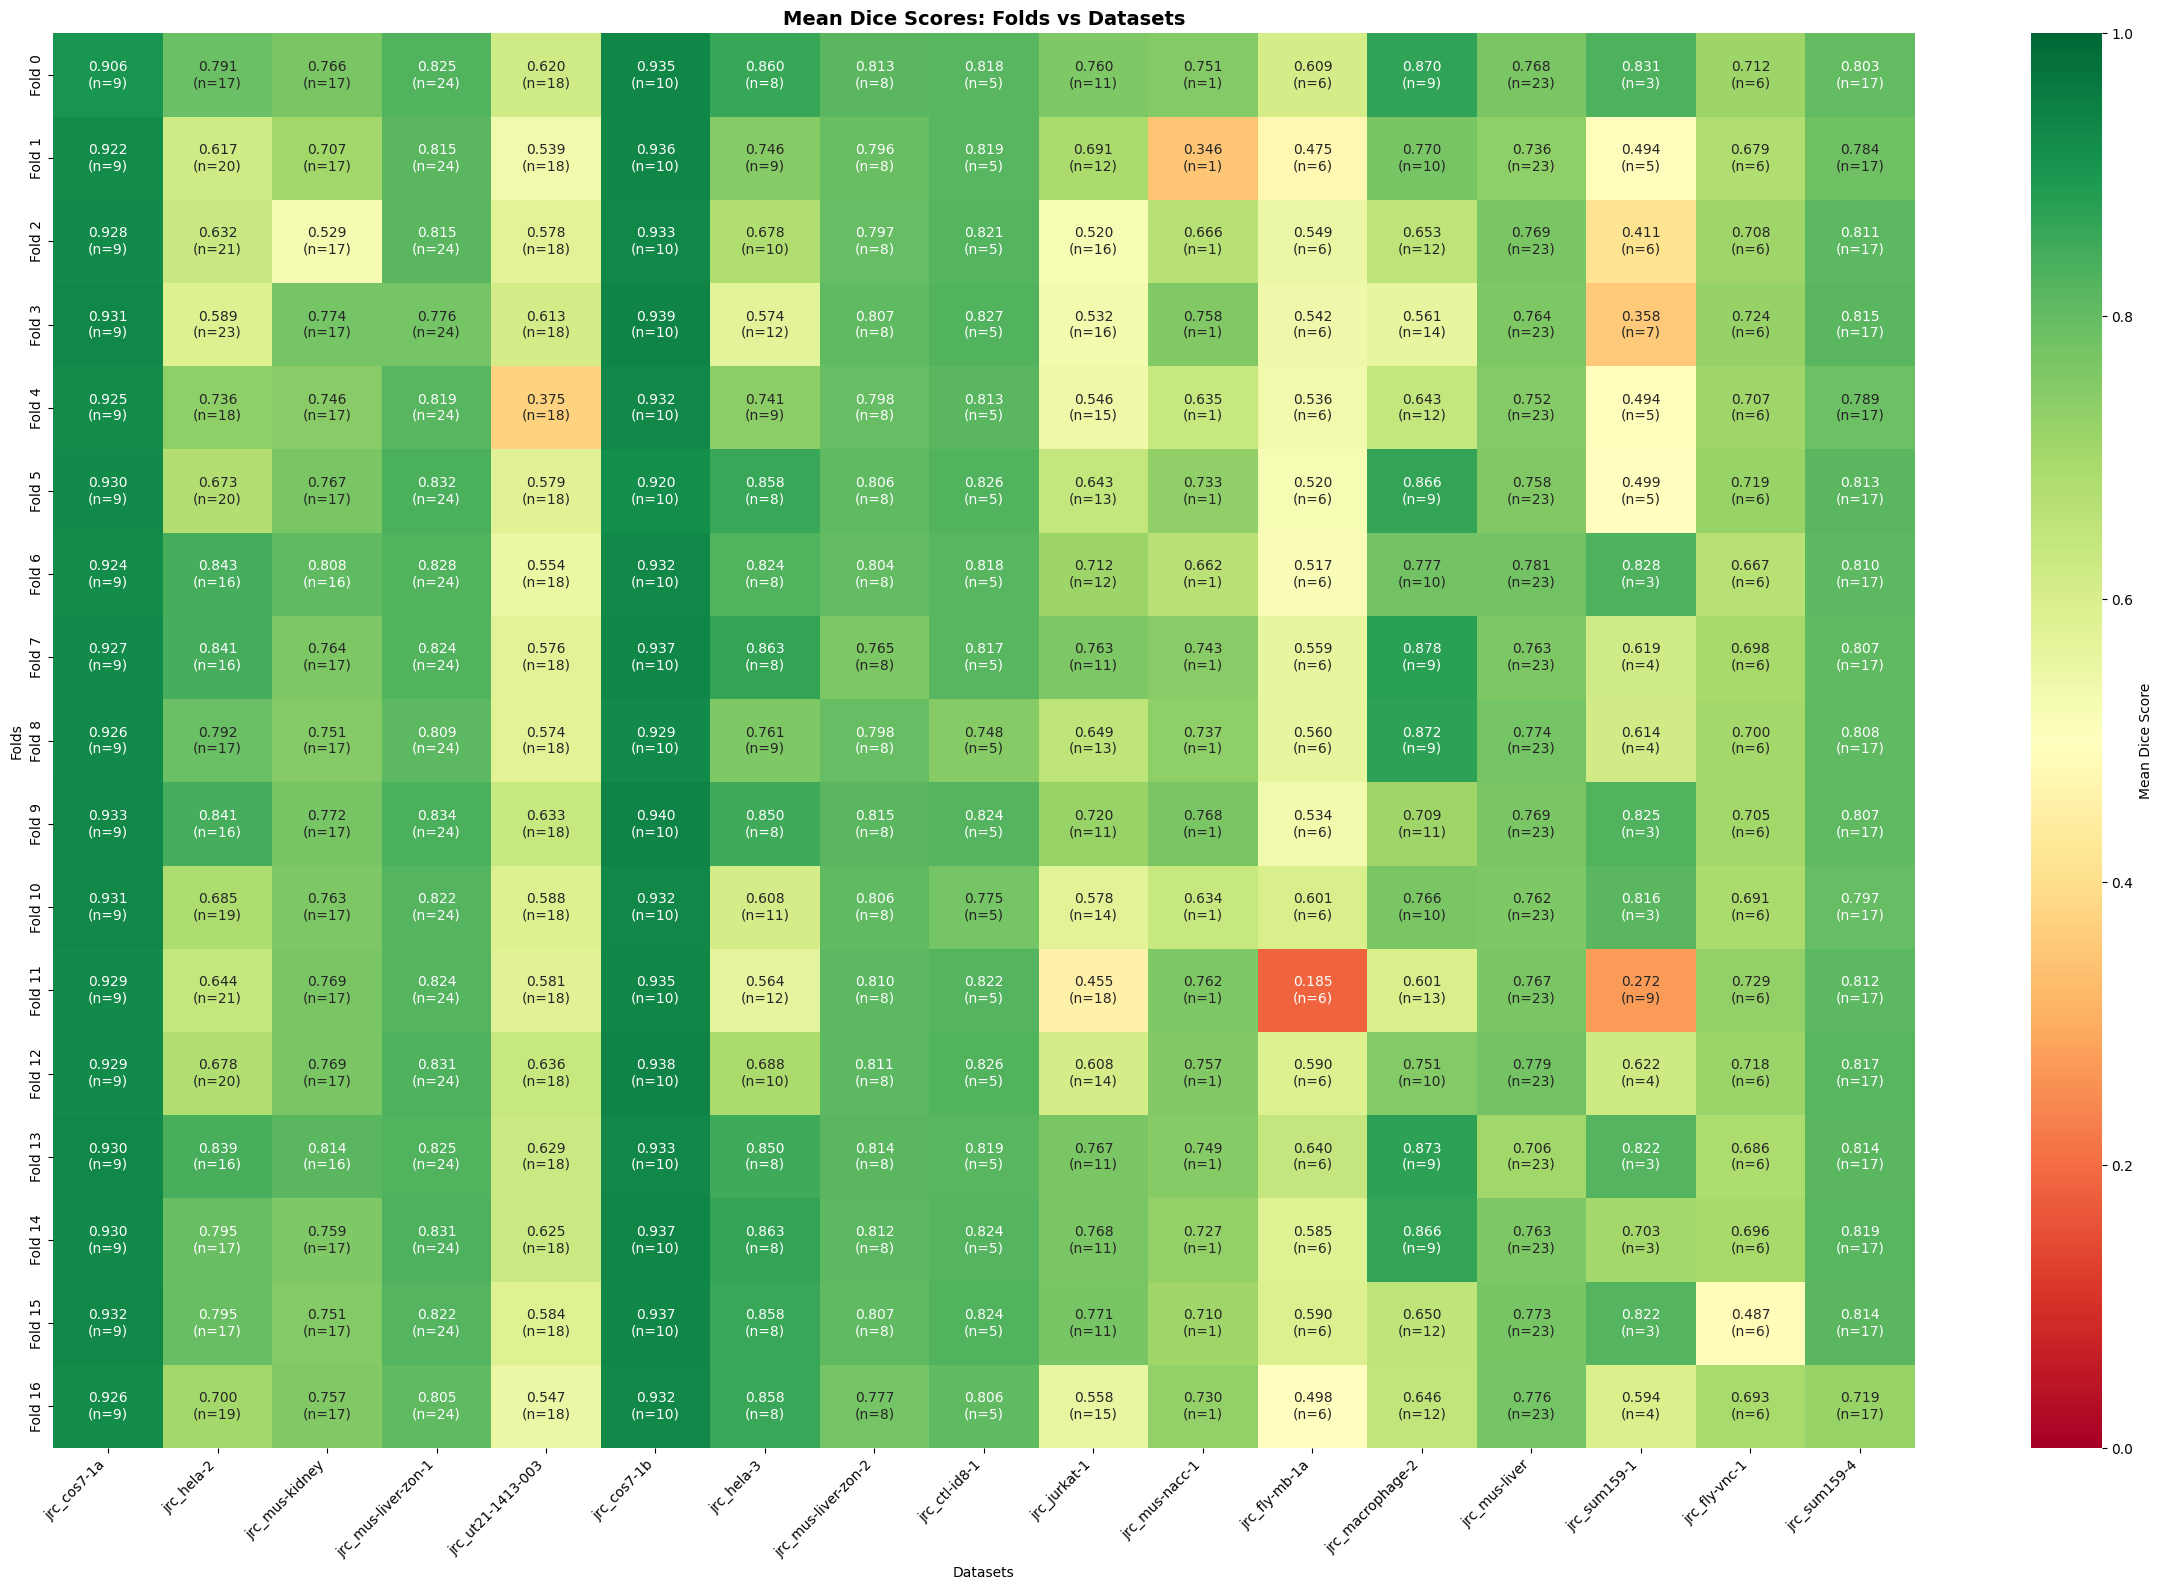

In [33]:
plot_folds_summary_heatmap(dice_scores_folds, dataset2files, figsize=(24, 16))

Results for fold 11


/tmp/ipykernel_3333585/2694912757.py:143: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot([dataset2dice[dataset] for dataset in dataset2dice.keys()],


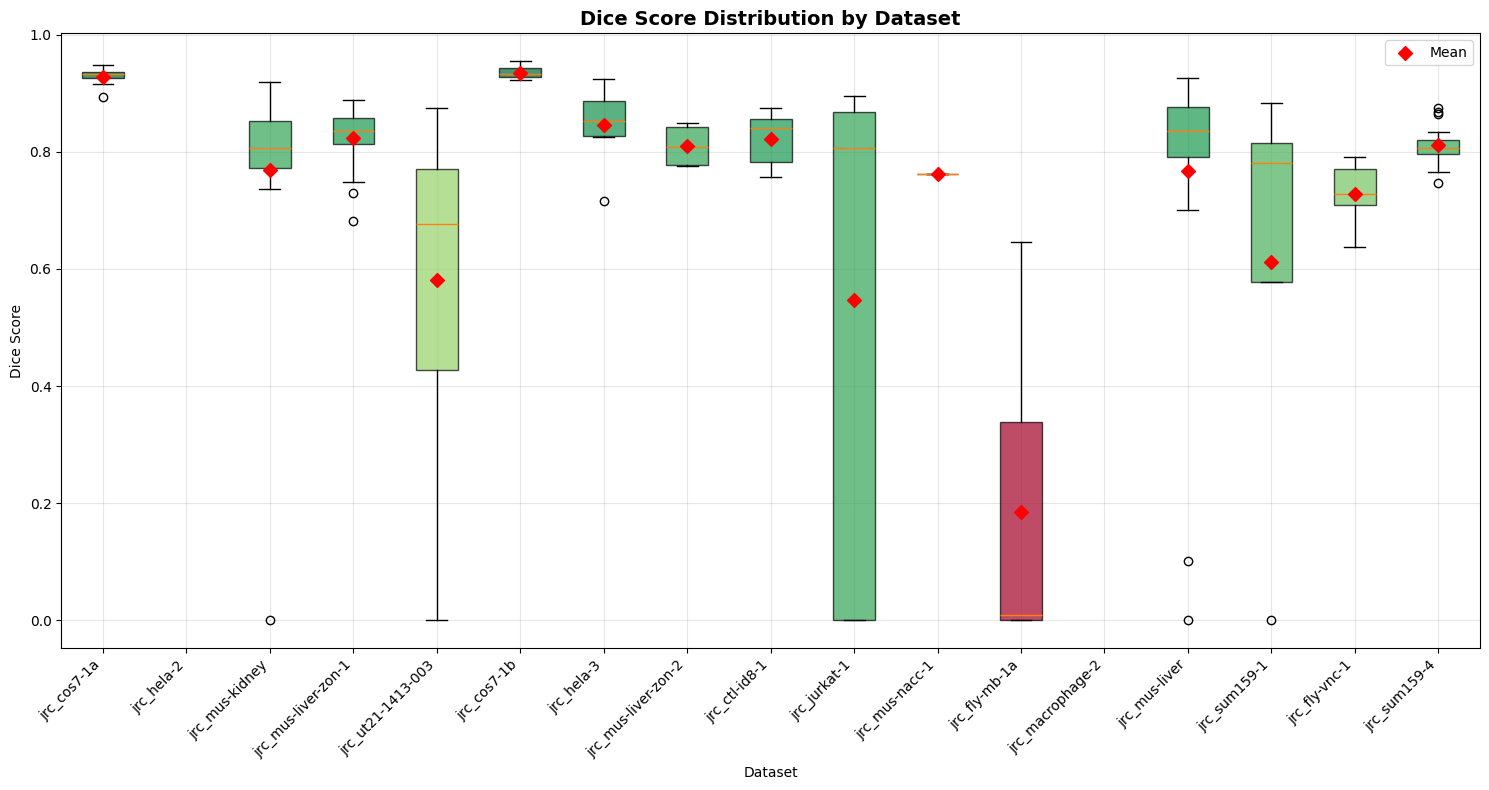

In [35]:
# ER Classification, by fold
fold = 11
print("Results for fold", fold)
dataset2dice = {k:[dice_scores_folds[fold][f"{f}.tif"] for f in v if not np.isnan(dice_scores[f"{f}.tif"])] for k,v in dataset2files.items()}
plot_dataset_boxplots(dataset2dice)

## Inspect Individual Cases by Dataset

### Setup

In [14]:
os.environ["nnUNet_raw"] = "/acfs-home/ash4001/ash4001/image-segment/data/cellmap-segmentation-challenge/data/nnUNet_data/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/acfs-home/ash4001/ash4001/image-segment/data/cellmap-segmentation-challenge/data/nnUNet_data/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/acfs-home/ash4001/ash4001/image-segment/data/cellmap-segmentation-challenge/data/nnUNet_data/nnUNet_results"

In [15]:
img_path = os.path.join(os.environ.get("nnUNet_raw"), "Dataset111_CellMapER/imagesTr")
ground_path = os.path.join(os.environ.get("nnUNet_raw"), "Dataset111_CellMapER/labelsTr")
pred_path = os.path.join(os.environ.get("nnUNet_results"), "Dataset111_CellMapER/nnUNetTrainer__nnUNetPlans__3d_fullres/crossval_results_folds_0_1_2_3_4/postprocessed")
#pred_path = os.path.join(os.environ.get("nnUNet_results"), "Dataset111_CellMapER/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_0/pred")
os.path.exists(img_path), os.path.exists(ground_path), os.path.exists(pred_path)

(True, True, True)

### Visualize

In [16]:
len(dataset2files['jrc_fly-mb-1a'])

6

image:


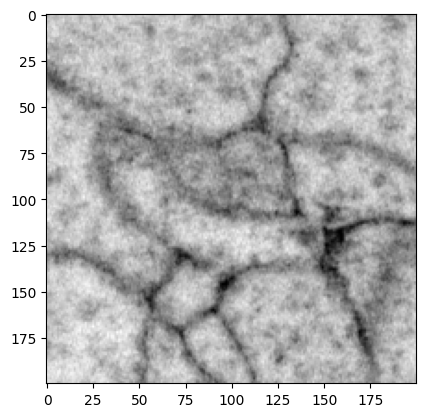

ground:


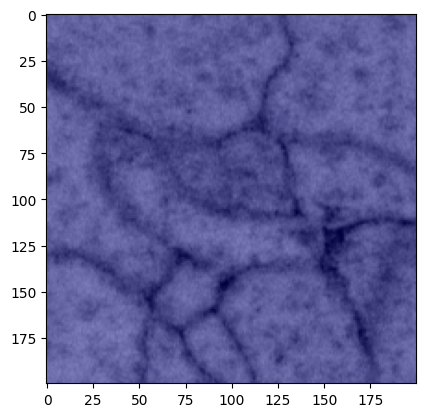

pred:


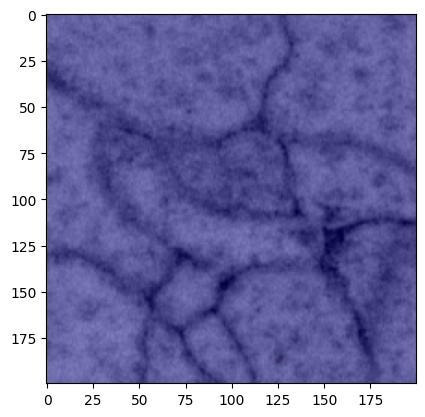

In [17]:
f = dataset2files['jrc_fly-mb-1a'][0]
data = f"{f}.tif"
img = tifffile.imread(os.path.join(img_path, data.replace(".tif", "_0000.tif")))
ground = tifffile.imread(os.path.join(ground_path, data))
pred = tifffile.imread(os.path.join(pred_path, data))


print("image:")
plt.imshow(img[img.shape[0] // 2, :, :], cmap='gray')
plt.show()

print("ground:")
plt.imshow(img[img.shape[0] // 2, :, :], cmap='gray')
plt.imshow(ground[img.shape[0] // 2, :, :], alpha=0.5, cmap='jet')
plt.show()
print("pred:")
plt.imshow(img[img.shape[0] // 2, :, :], cmap='gray')
plt.imshow(pred[img.shape[0] // 2, :, :], alpha=0.5, cmap='jet')
plt.show()

In [56]:
plot_3d_downsampled(ground, target_size=32, surface_count=6)#, color_scale='Greys')

Downsampled from (200, 200, 200) to (32, 32, 32)


In [47]:
plot_3d_downsampled(pred, target_size=32, surface_count=6)#, color_scale='Greys')

Downsampled from (200, 200, 200) to (32, 32, 32)


In [48]:
pred_1d = np.nan_to_num(pred.flatten(), 0)
ground_1d = np.nan_to_num(ground.flatten(), 0)
dice_similarity = 1 - dice(ground_1d, pred_1d) # scipy's dice measures dissimilarity
print(dice_similarity)

0.0


In [72]:
print(img.shape)

# Downsample spatially for faster loading
def quick_view(volume, downsample=4):
    # Take every 4th pixel in x,y and every 2nd slice in z
    downsampled = volume[::4*downsample, ::downsample, ::downsample]
    
    fig = px.imshow(downsampled, animation_frame=0, 
                    color_continuous_scale='gray',
                    title=f"EM Volume (downsampled {downsample}x)")
    return fig

# If volume is (z, y, x):
fig = quick_view(img, downsample=2)
fig.show()

(200, 200, 200)


In [73]:
# If volume is (z, y, x):
fig = px.imshow(img[::10, :, :], animation_frame=0, 
                title="EM Volume Z-Slice Viewer",
                labels={'animation_frame': 'Z-slice'},
                color_continuous_scale='gray')

px.imshow(img[::10, :, :], animation_frame=0, 
                title="EM Volume Z-Slice Viewer",
                labels={'animation_frame': 'Z-slice'},
                color_continuous_scale='gray')

fig.show()

In [78]:
def create_rgb_overlay(volume, segmentation, seg_alpha=0.5):
    """Create RGB composite before plotting"""
    
    # Normalize both arrays to 0-1
    vol_norm = (volume - volume.min()) / (volume.max() - volume.min())
    seg_norm = (segmentation - segmentation.min()) / (segmentation.max() - segmentation.min())
    
    # Create RGB array
    rgb_volume = np.zeros((*volume.shape, 3))
    
    for i in range(volume.shape[0]):
        # Grayscale for EM volume (R=G=B)
        rgb_volume[i, :, :, 0] = vol_norm[i]  # Red
        rgb_volume[i, :, :, 1] = vol_norm[i]  # Green  
        rgb_volume[i, :, :, 2] = vol_norm[i]  # Blue
        
        # Add segmentation in red channel
        mask = seg_norm[i] > 0
        rgb_volume[i, :, :, 0] = np.where(mask, 
                                         vol_norm[i] * (1-seg_alpha) + seg_norm[i] * seg_alpha,
                                         vol_norm[i])

    return rgb_volume

rgb_volume = create_rgb_overlay(img, pred, seg_alpha=0.5)
fig = px.imshow(rgb_volume[::10, ::, ::], animation_frame=0, title="EM + Segmentation Composite")
fig.show()

In [81]:
# zoomed-in redering for z-axis
fig = px.imshow(rgb_volume[90:120:2, ::, ::], animation_frame=0, title="EM + Segmentation Composite")
fig.show()

# Try on datasets outside of Janelia's list

In [3]:
img_dir = "../data/empiar/ftp.ebi.ac.uk/1857 - Obese Climp-63 Liver/1857 Obese Climp-63 Raw/"
img_name_start = "1857_Obese_Climp63_raw_T001_Z"
img_name_end = "_C07.tif"

# get files in dir and assert they have the start and end
all_files = os.listdir(img_dir)
img_files = [f for f in all_files if f.startswith(img_name_start) and f.endswith(img_name_end)]
img_files = sorted(img_files, key=lambda x: int(x.replace(img_name_start, "").replace(img_name_end, "")))
len(img_files)

# order file names by z index
z_files = {}
for f in img_files:
    z_idx = int(f.replace(img_name_start, "").replace(img_name_end, ""))
    z_files[z_idx] = f

z_indices = sorted(z_files.keys())
z_indices[:10], z_files[z_indices[0]]

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], '1857_Obese_Climp63_raw_T001_Z001_C07.tif')

In [4]:
# construct an arbitrary 200 x 200 x 200 ndarray
volume = np.zeros((200, 200, 200), dtype=np.uint8)
z_start = 200
y_start = 200
x_start = 200
for z in tqdm(range(200), "Loading slices"):
    img = tifffile.imread(os.path.join(img_dir, z_files[z + z_start]))
    volume[z] = img[y_start:y_start+200, x_start:x_start+200]
print(volume.shape)

Loading slices: 100%|██████████| 200/200 [00:27<00:00,  7.34it/s]

(200, 200, 200)


(200, 200)


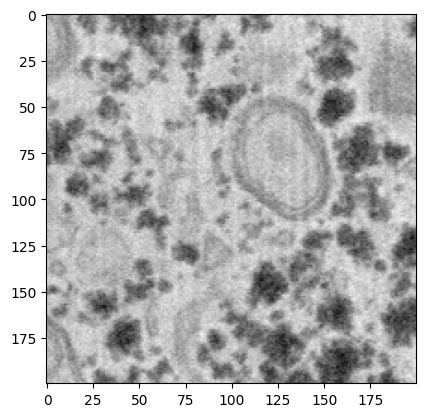

In [5]:
# visualize an arbitrary slice
img = volume[100]
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

In [3]:
from nnunetv2.paths import nnUNet_results, nnUNet_raw
import torch
from batchgenerators.utilities.file_and_folder_operations import join
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO

# nnUNetv2_predict -d 3 -f 0 -c 3d_lowres -i imagesTs -o imagesTs_predlowres --continue_prediction
fold = 4

# instantiate the nnUNetPredictor
predictor = nnUNetPredictor(
    tile_step_size=0.5,
    use_gaussian=True,
    use_mirroring=True,
    perform_everything_on_device=True,
    device=torch.device('cuda', 0),
    verbose=False,
    verbose_preprocessing=False,
    allow_tqdm=True
)
# initializes the network architecture, loads the checkpoint
predictor.initialize_from_trained_model_folder(
    join("../data/nnUNet_data_downsampled/nnUNet_results/", 'Dataset111_CellMapER/nnUNetTrainer__nnUNetPlans__3d_fullres'),
    use_folds=(fold,),
    checkpoint_name='checkpoint_best.pth',
)

In [7]:
volume.shape

(200, 200, 200)

In [8]:
from nnunetv2.imageio.tif_reader_writer import Tiff3DIO
img, props = Tiff3DIO().read_images(["../data/nnUNet_data_downsampled/nnUNet_raw/Dataset111_CellMapER/imagesTr/em_000_0000.tif"])
#ret = predictor.predict_single_npy_array(img, props, None, None, False)
plt.imshow(img[0, img.shape[1] // 2, :, :], cmap='gray')
plt.show()

In [4]:
vol_unsqueeze = np.expand_dims(volume, axis=0)  # add channel dim
props = {'spacing': [8.0, 8.0, 8.0]}
#props = {'spacing': [8.0, 8.0, 8.0], 'shape_before_cropping': (200, 200, 200), 'bbox_used_for_cropping': [[0, 200], [0, 200], [0, 200]], 'shape_after_cropping_and_before_resampling': (200, 200, 200)}
print(vol_unsqueeze.shape)

(1, 200, 200, 200)


In [5]:
pred = predictor.predict_single_npy_array(vol_unsqueeze, props, None, None, False)
print(pred.shape, pred.dtype, np.unique(pred))

100%|██████████| 144/144 [03:40<00:00,  1.53s/it]


(200, 200, 200) uint8 [0 1]


In [6]:
# save image and pred in working space as tif file
tifffile.imwrite("./working/em_volume.tif", volume)
tifffile.imwrite("./working/em_volume_pred.tif", pred.astype(np.uint8))

### ER Pred Downsampled Model

In [3]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np

volume = tifffile.imread("./working/em_volume.tif")
pred = tifffile.imread("./working/em_volume_pred.tif")

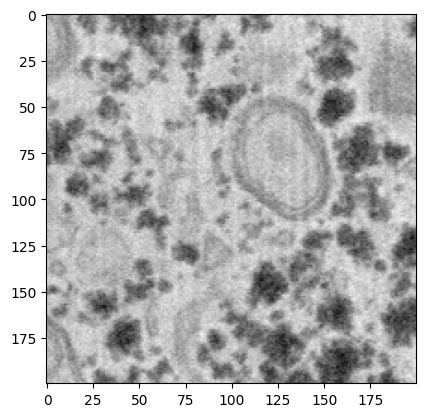

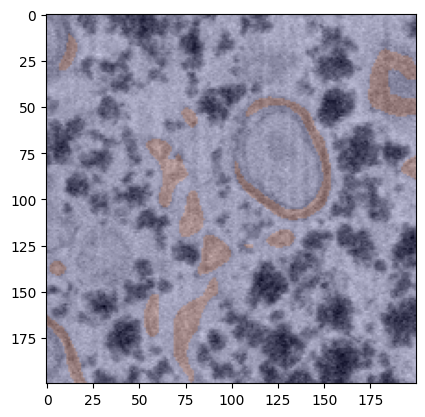

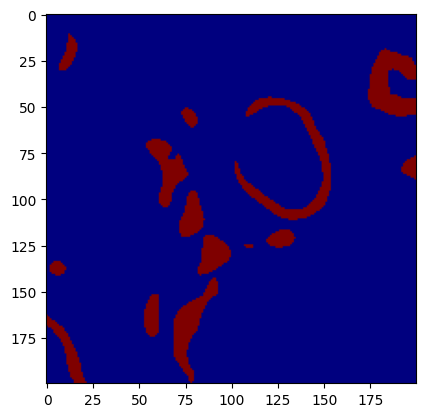

In [ ]:
# as of epoch 400

plt.imshow(volume[volume.shape[0] // 2, :, :], cmap='gray')
plt.show()

plt.imshow(volume[volume.shape[0] // 2, :, :], cmap='gray')
plt.imshow(pred[pred.shape[0] // 2, :, :], cmap='jet', alpha=0.2)
plt.show()

plt.imshow(pred[pred.shape[0] // 2, :, :], cmap='jet')
plt.show()

### ER Pred Original Model

In [1]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np

volume = tifffile.imread("./working/em_volume_og.tif")
pred = tifffile.imread("./working/em_volume_pred_og.tif")

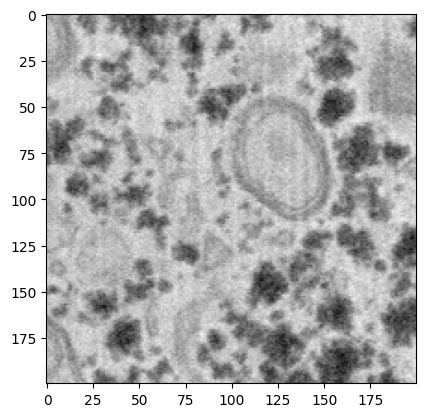

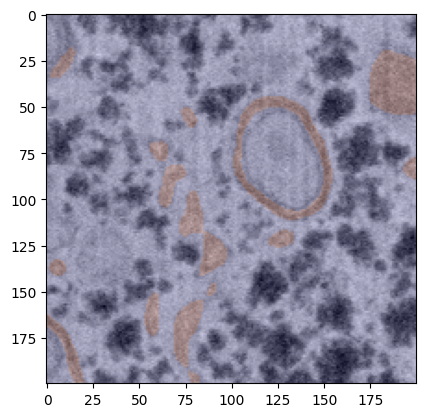

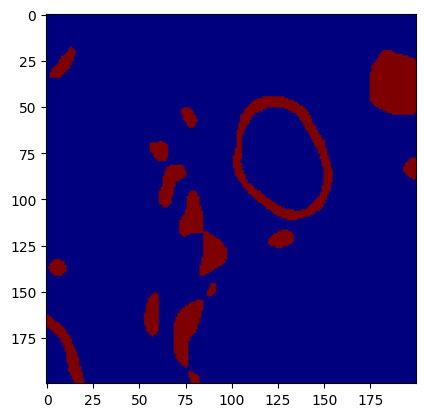

In [2]:
plt.imshow(volume[volume.shape[0] // 2, :, :], cmap='gray')
plt.show()

plt.imshow(volume[volume.shape[0] // 2, :, :], cmap='gray')
plt.imshow(pred[pred.shape[0] // 2, :, :], cmap='jet', alpha=0.2)
plt.show()

plt.imshow(pred[pred.shape[0] // 2, :, :], cmap='jet')
plt.show()

### Background pred

In [1]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np

volume = tifffile.imread("./working/em_volume_bg.tif")
pred = tifffile.imread("./working/em_volume_pred_bg.tif")

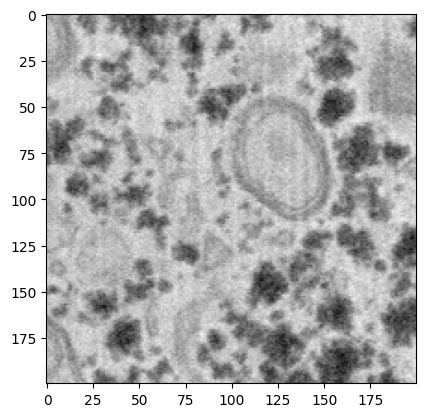

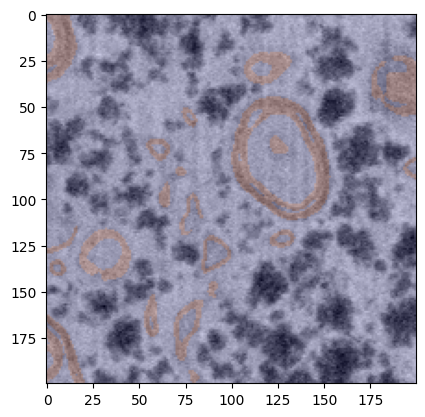

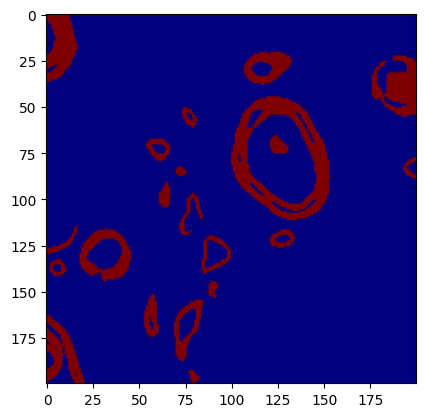

In [2]:
plt.imshow(volume[volume.shape[0] // 2, :, :], cmap='gray')
plt.show()

plt.imshow(volume[volume.shape[0] // 2, :, :], cmap='gray')
plt.imshow(pred[pred.shape[0] // 2, :, :], cmap='jet', alpha=0.2)
plt.show()

plt.imshow(pred[pred.shape[0] // 2, :, :], cmap='jet')
plt.show()